Music Transformer

In [ ]:
!pip install pretty_midi music21

In [ ]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

In [ ]:
import os, json, pickle
import processor
from processor import encode_midi, decode_midi
import pretty_midi

In [ ]:
from processor import (_control_preprocess, _note_preprocess,
        _divide_note, _make_time_sift_events, _snote2events)

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip

--2025-03-15 05:46:47--  https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.207, 74.125.196.207, 74.125.134.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59243107 (56M) [application/zip]
Saving to: ‘maestro-v2.0.0-midi.zip’

maestro-v2.0.0-midi 100%[===================>]  56.50M   152MB/s    in 0.4s    

2025-03-15 05:46:48 (152 MB/s) - ‘maestro-v2.0.0-midi.zip’ saved [59243107/59243107]



In [ ]:
file= "maestro-v2.0.0/maestro-v2.0.0.json"
with open(file,'r') as fd:
  maestro_json =json.load(fd)
maestro_json

In [ ]:
os.makedirs("train", exist_ok=True)
os.makedirs("val", exist_ok=True)
os.makedirs("test", exist_ok=True)

In [ ]:
for file in maestro_json:
  midi = rf'maestro-v2.0.0/{file["midi_filename"]}'
  split_type = file['split']
  file_name = midi.split('/')[-1] + '.pickle'
  if split_type == 'train':
    file_ = rf'train/{file_name}'
  elif (split_type == 'validation'):
    file_ = rf'val/{file_name}'
  elif (split_type =='test'):
    file_ = rf'test/{file_name}'
  prepared = encode_midi(midi)

  with open(file_, 'wb') as fd:
    pickle.dump(prepared, fd)

In [ ]:
train_size = len(os.listdir('train/'))
val_size = len(os.listdir('val/'))
test_size = len(os.listdir('test/'))
train_size, val_size, test_size

(967, 137, 178)

Tokenize files

In [ ]:
file_name = 'MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6.midi'
events, notes = [], []
song = pretty_midi.PrettyMIDI(rf'maestro-v2.0.0/2018/{file_name}')
for instrument in song.instruments:
  inst_notes = instrument.notes
  ctrls = _control_preprocess(
      [ctrl for ctrl in instrument.control_changes if ctrl.number ==64])
  notes += _note_preprocess(ctrls, inst_notes)
dnotes = _divide_note(notes)
dnotes.sort(key=lambda x: x.time)
for i in range(5):
  print(dnotes[i])

current_time = 0
current_velocity = 0
for snote in dnotes:
  events += _make_time_sift_events(prev_time=current_time, post_time=snote.time)
  events += _snote2events(snote=snote, prev_vel=current_velocity)
  current_time = snote.time
  current_velocity = snote.velocity

indexes = [e.to_int() for e in events]
for i in range(10):
  print(events[i])

<[SNote] time: 0.9557291666666666 type: note_on, value: 22, velocity: 67>
<[SNote] time: 0.9622395833333333 type: note_on, value: 34, velocity: 63>
<[SNote] time: 1.2994791666666665 type: note_on, value: 41, velocity: 58>
<[SNote] time: 1.4231770833333333 type: note_on, value: 46, velocity: 55>
<[SNote] time: 1.53125 type: note_on, value: 50, velocity: 68>
<Event type: time_shift, value: 95>
<Event type: velocity, value: 16>
<Event type: note_on, value: 22>
<Event type: time_shift, value: 0>
<Event type: velocity, value: 15>
<Event type: note_on, value: 34>
<Event type: time_shift, value: 33>
<Event type: velocity, value: 14>
<Event type: note_on, value: 41>
<Event type: time_shift, value: 11>


In [ ]:
max_seq = 2048
def create_data(folder):
  files = [os.path.join(folder, filename) for filename in os.listdir(folder)]
  data = []
  for file_ in files:
    with open(file_, 'rb') as fd:
      music_prepared = pickle.load(fd)
    music_prepared = torch.LongTensor(music_prepared)
    x = torch.full((max_seq, ), 389, dtype=torch.long)
    y = torch.full((max_seq, ), 389, dtype=torch.long)
    length = len(music_prepared)
    if length <= max_seq:
      x[:length] = music_prepared
      y[:length-1] = music_prepared[1:]
      y[length-1] = 388
    else:
      x = music_prepared[:max_seq]
      y = music_prepared[1:max_seq+1]
    data.append((x, y))
  return data

train = create_data('train')
val = create_data('val')
test = create_data('test')

In [ ]:
(train_0, _),  (val_0, _),  (test_0, _) = train[0], val[0], test[0]
train_0.shape, train_0, val_0.shape, val_0, test_0.shape, test_0,

(torch.Size([2048]),
 tensor([347, 372,  68,  ...,  58, 266, 191]),
 torch.Size([2048]),
 tensor([354, 369,  53,  ..., 191, 279, 368]),
 torch.Size([2048]),
 tensor([353, 374,  79,  ..., 257, 195, 322]))

In [ ]:
decode_midi(val_0.cpu().numpy(), 'validation_file_0.midi')

In [ ]:
batch_size=2
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
val_loader = DataLoader(val, batch_size=batch_size)

Build GPT like to generate music
- Hyperparameters
- Music Transformer
- Training the Transformer
- Music Generation

In [ ]:
''' Hyperparameters '''
class Config():
  def __init__(self):
    self.n_layer = 6
    self.n_head = 8
    self.n_embd = 512
    self.vocab_size = 390
    self.block_size = 2048
    self.embed_pdrop = 0.1
    self.resid_pdrop = 0.1
    self.attn_pdrop = 0.1
    self.layer_norm_epsilon = 1e-5

config = Config()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
''' Transformer '''
class GELU(nn.Module):
  def forward(self, x):
    return 0.5 * x * (
      1.0 +torch.tanh(math.sqrt(2.0/math.pi) * (x +0.044715 *torch.pow(x, 3))))

In [ ]:
class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.causal_attention = nn.Linear(config.n_embd, 3 * config.n_embd, bias=False)
    self.causal_projection = nn.Linear(config.n_embd, config.n_embd)
    self.attn_dropout = nn.Dropout(config.attn_pdrop)
    self.resid_dropout = nn.Dropout(config.resid_pdrop)
    self.register_buffer('bias', torch.tril(torch.ones(config.block_size,
        config.block_size)).view(1, 1, config.block_size, config.block_size))
    self.n_head = config.n_head
    self.n_embd = config.n_embd

  def forward(self, x):
    B, T, C = x.size()
    query, key, value = self.causal_attention(x).split(self.n_embd, dim=2)
    query = query.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
    key = key.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
    value = value.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
    attention = (query @ key.transpose(-2, -1)) * (1.0 / math.sqrt(key.size(-1)))
    attention = attention.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
    attention = F.softmax(attention, dim=-1)
    attention = self.attn_dropout(attention)
    y = attention @ value
    y = y.transpose(1,2).contiguous().view(B, T, C)
    y = self.resid_dropout(self.causal_projection(y))
    return y

In [ ]:
class Block(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.ln1 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.attention = CausalSelfAttention(config)
    self.ln2 = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon)
    self.mlp = nn.ModuleDict(dict(
        causal_fc = nn.Linear(config.n_embd, 4 * config.n_embd),
        causal_projection = nn.Linear(4 * config.n_embd, config.n_embd),
        act = GELU(),
        dropout = nn.Dropout(config.resid_pdrop),
    ))
    m = self.mlp
    self.mlpf = lambda x: m.dropout(m.causal_projection(m.act(m.causal_fc(x))))

  def forward(self, x):
    x = x + self.attention(self.ln1(x))
    x = x + self.mlpf(self.ln2(x))
    return x

In [ ]:
GELU(), CausalSelfAttention(config), Block(config)

(GELU(),
 CausalSelfAttention(
   (causal_attention): Linear(in_features=512, out_features=1536, bias=False)
   (causal_projection): Linear(in_features=512, out_features=512, bias=True)
   (attn_dropout): Dropout(p=0.1, inplace=False)
   (resid_dropout): Dropout(p=0.1, inplace=False)
 ),
 Block(
   (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
   (attention): CausalSelfAttention(
     (causal_attention): Linear(in_features=512, out_features=1536, bias=False)
     (causal_projection): Linear(in_features=512, out_features=512, bias=True)
     (attn_dropout): Dropout(p=0.1, inplace=False)
     (resid_dropout): Dropout(p=0.1, inplace=False)
   )
   (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
   (mlp): ModuleDict(
     (causal_fc): Linear(in_features=512, out_features=2048, bias=True)
     (causal_projection): Linear(in_features=2048, out_features=512, bias=True)
     (act): GELU()
     (dropout): Dropout(p=0.1, inplace=False)
   )
 ))

In [ ]:
class Model(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.block_size = config.block_size
    self.transformer = nn.ModuleDict(dict(
        wte = nn.Embedding(config.vocab_size, config.n_embd),
        wpe = nn.Embedding(config.block_size, config.n_embd),
        drop = nn.Dropout(config.embed_pdrop),
        h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
        ln_f = nn.LayerNorm(config.n_embd, eps=config.layer_norm_epsilon), ))
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
    for pn,p in self.named_parameters():
      if pn.endswith('causal_projection.weight'):
        torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 *config.n_layer))

  def forward(self, idx, targets=None):
    B, T = idx.size()
    position_embedding = torch.arange(
                      0, T, dtype=torch.long, device=idx.device).unsqueeze(0)
    token_embeddings = self.transformer.wte(idx)
    position_embeddings = self.transformer.wpe(position_embedding)
    x = self.transformer.drop(token_embeddings + position_embeddings)
    for block in self.transformer.h:
      x = block(x)
    x = self.transformer.ln_f(x)
    logits = self.lm_head(x)
    return logits

In [ ]:
model = Model(config).to(device)
number_of_param = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {number_of_param}')
model

Number of parameters: 20354048


Model(
  (transformer): ModuleDict(
    (wte): Embedding(390, 512)
    (wpe): Embedding(2048, 512)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): CausalSelfAttention(
          (causal_attention): Linear(in_features=512, out_features=1536, bias=False)
          (causal_projection): Linear(in_features=512, out_features=512, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (causal_fc): Linear(in_features=512, out_features=2048, bias=True)
          (causal_projection): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((512,), eps=1e-05, elementwise_a

In [ ]:
''' Training '''
lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=388)

model.train()
for i in range(1, 100):
  training_loss = 0.
  for index, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(device)
    output = model(x)
    loss = loss_fn(output.view(-1, output.size(-1)), y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    training_loss += loss.item()
  print(f'Epoch: {i} Training loss: {training_loss / (index+1)}')

In [ ]:
torch.save(model.state_dict(), 'model_music_transformer.pth')
files.download('model_music_transformer.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
''' Music generation '''
prompt, _ = test[10]
prompt = prompt.to(device)
len_prompt = 250
file_ ='prompt.midi'
decode_midi(prompt.cpu().numpy(), file_)

In [ ]:
softmax = torch.nn.Softmax(dim=-1)
def sample(prompt, seq_length=1000, temperature=1):
  generated_sequence = torch.full(
      (1, seq_length), 389, dtype=torch.long).to(device)
  index = len(prompt)
  generated_sequence[..., :index] = prompt.type(torch.long).to(device)
  while index < seq_length:
    logits = model(generated_sequence[..., :index])
    y = softmax(logits/temperature)[..., :388]
    probs = y[:, index-1, :]
    distrib = torch.distributions.categorical.Categorical(probs=probs)
    next_token = distrib.sample()
    generated_sequence[:, index] = next_token
    index += 1
  return generated_sequence[:, :index]

In [ ]:
model.load_state_dict(torch.load('model_music_transformer.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

In [ ]:
file_name = 'prompt.midi'
prompt = torch.tensor(encode_midi(file_name))
generated_music = sample(prompt, seq_length=2026, temperature=1.5)
music_data = generated_music[0].cpu().numpy()
decode_midi(music_data, 'generated_music_HiTemp.midi')
files.download('generated_music_HiTemp.midi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import IPython.display as ipd
files.download('generated_music_HiTemp.midi')
ipd.Audio('generated_music_HiTemp.midi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!apt-get install musescore
!pip install music21

In [ ]:
from music21 import *
environment.set('musescoreDirectPNGPath', '/usr/bin/mscore')
from music21 import stream, note, meter, clef, duration, tempo

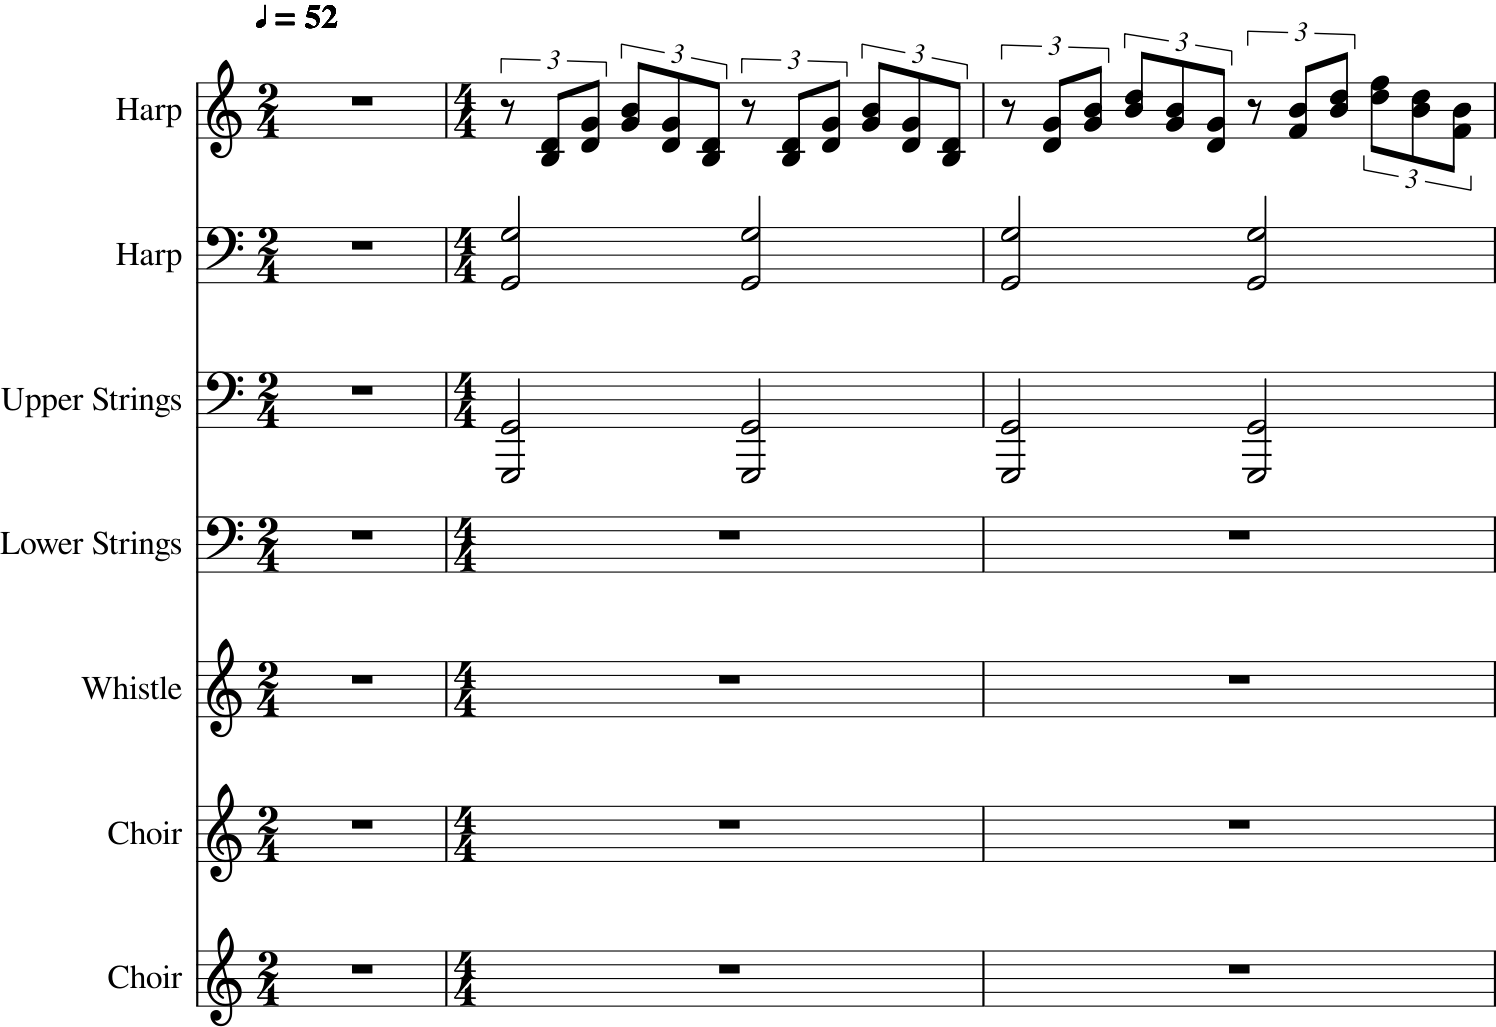

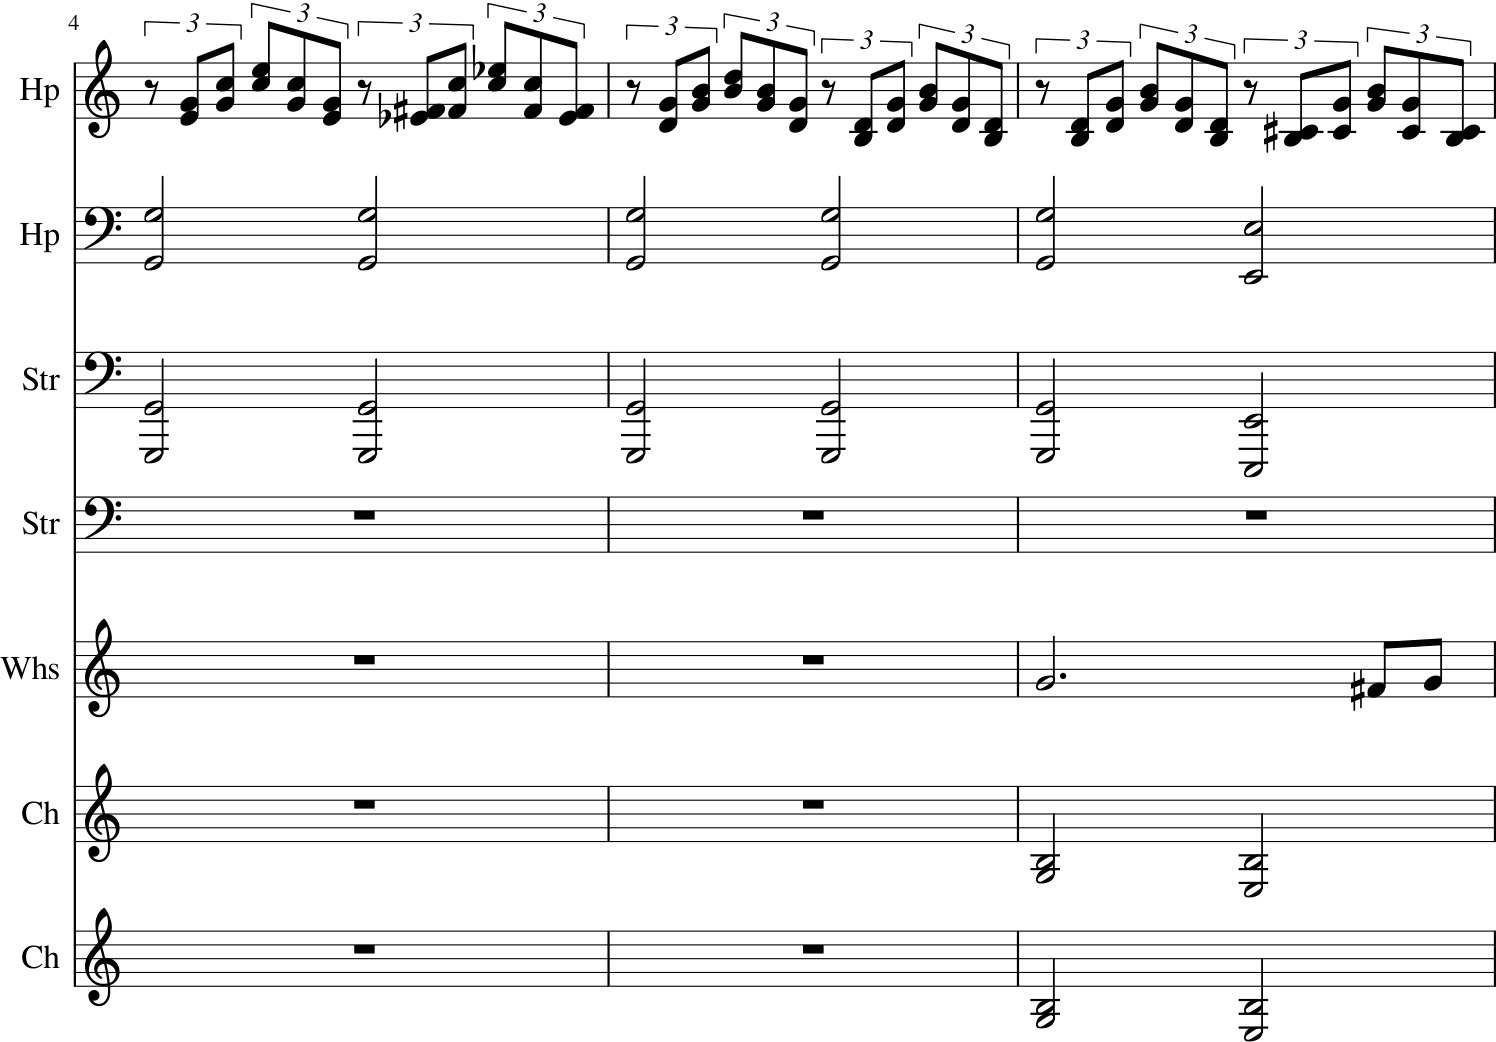

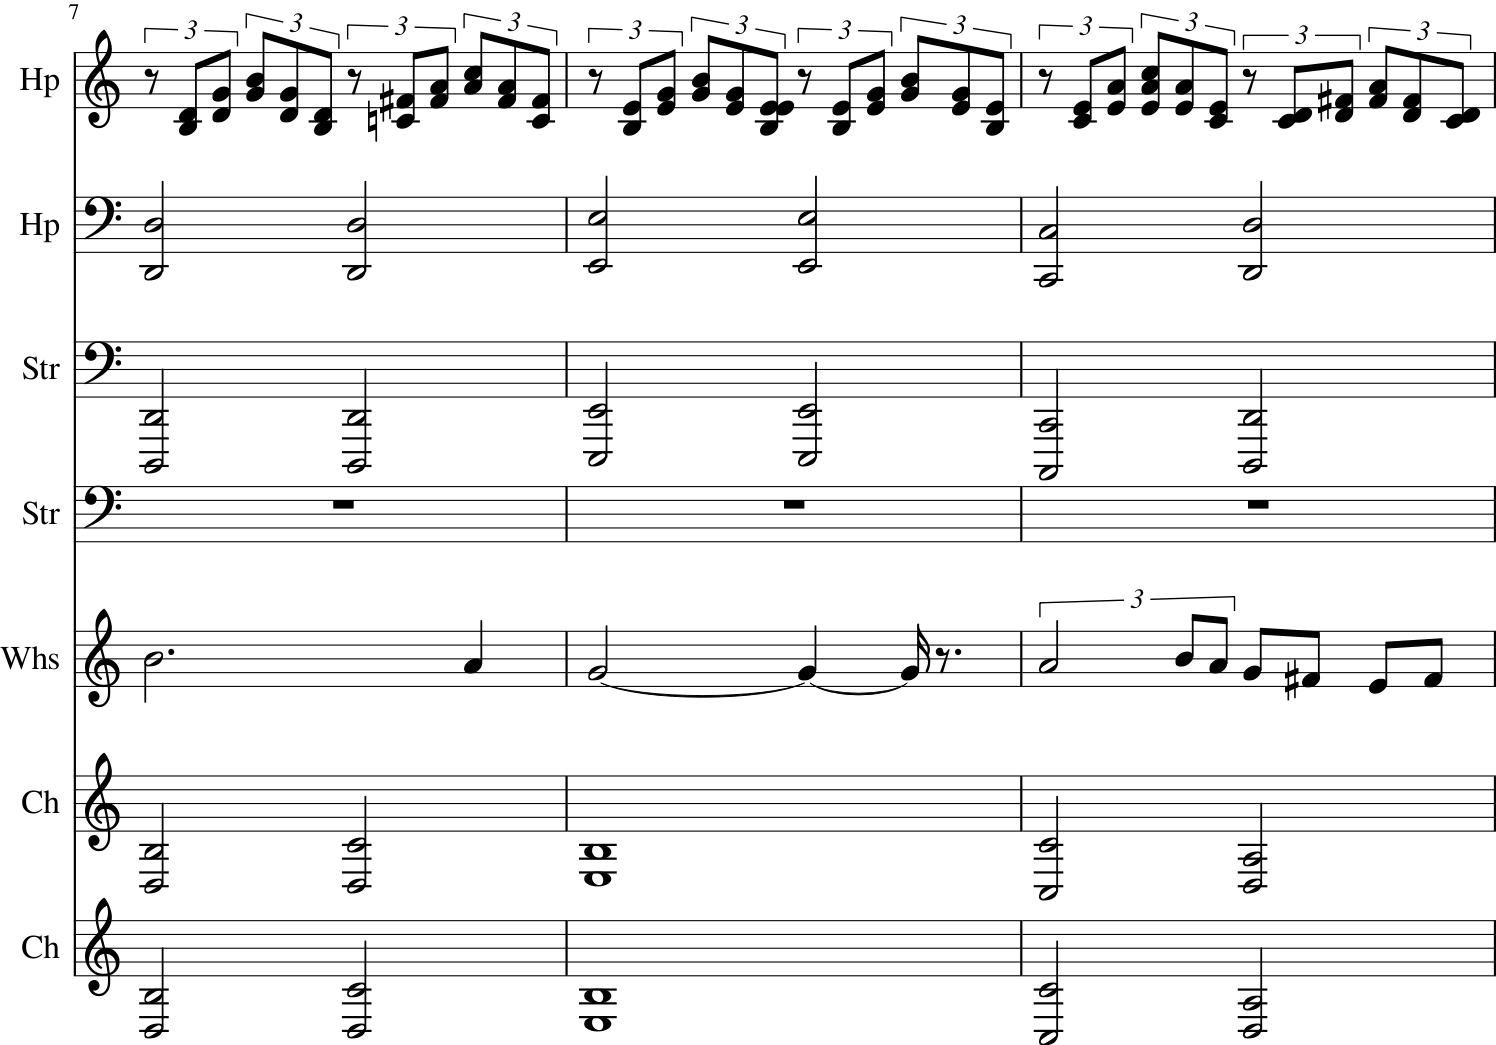

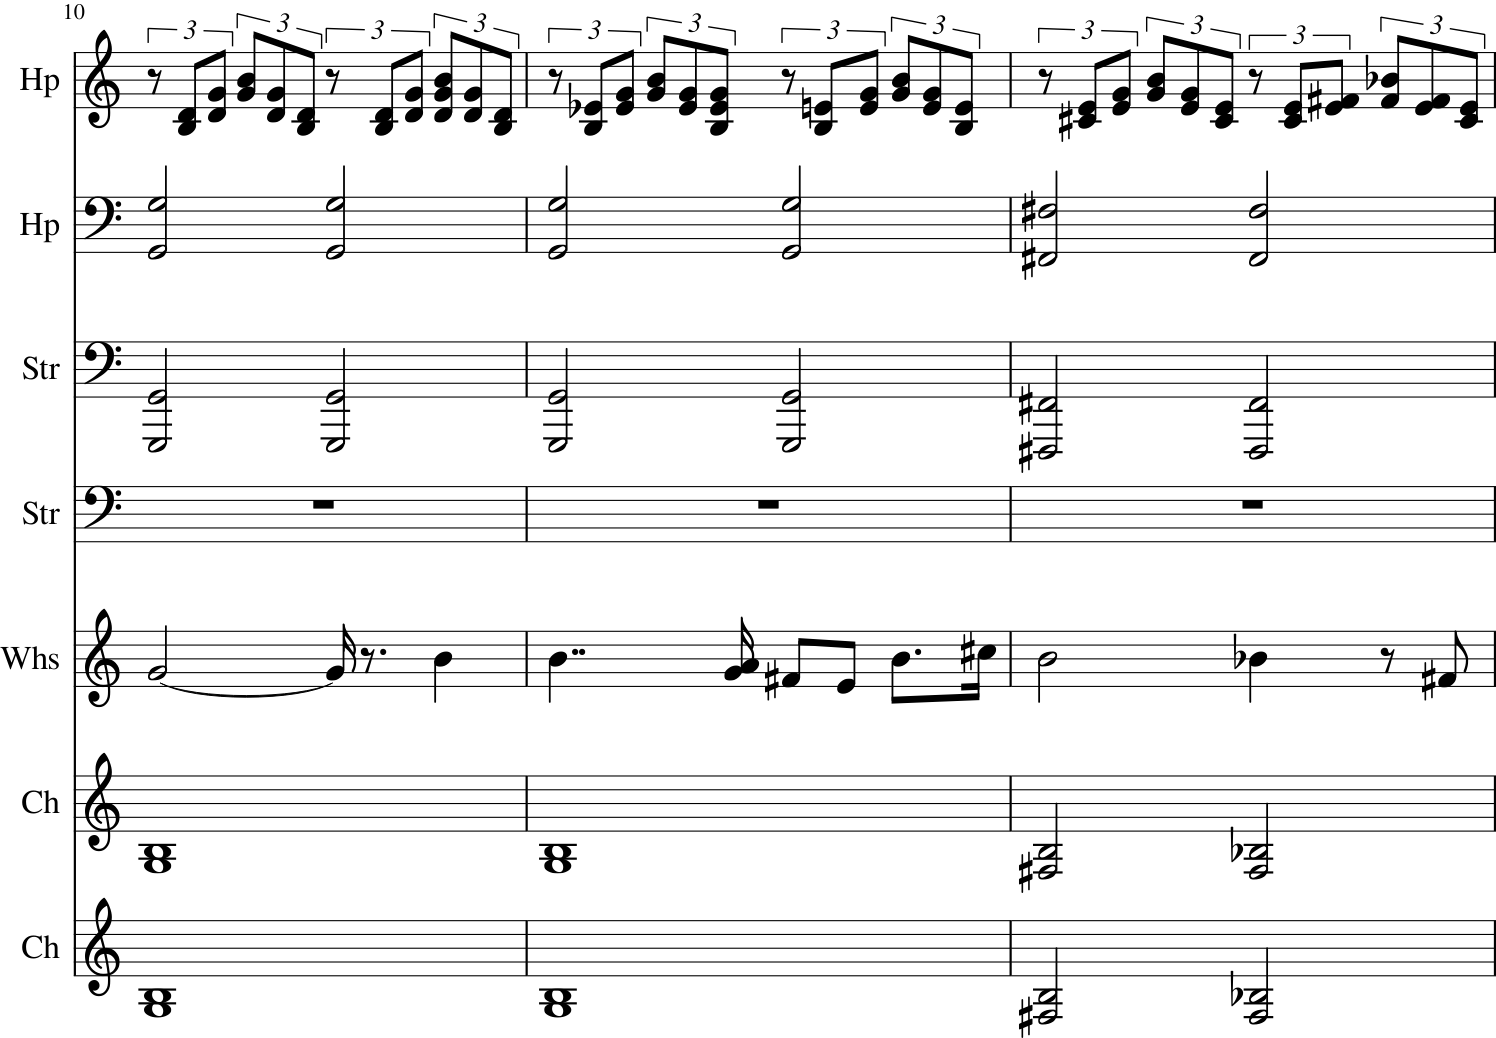

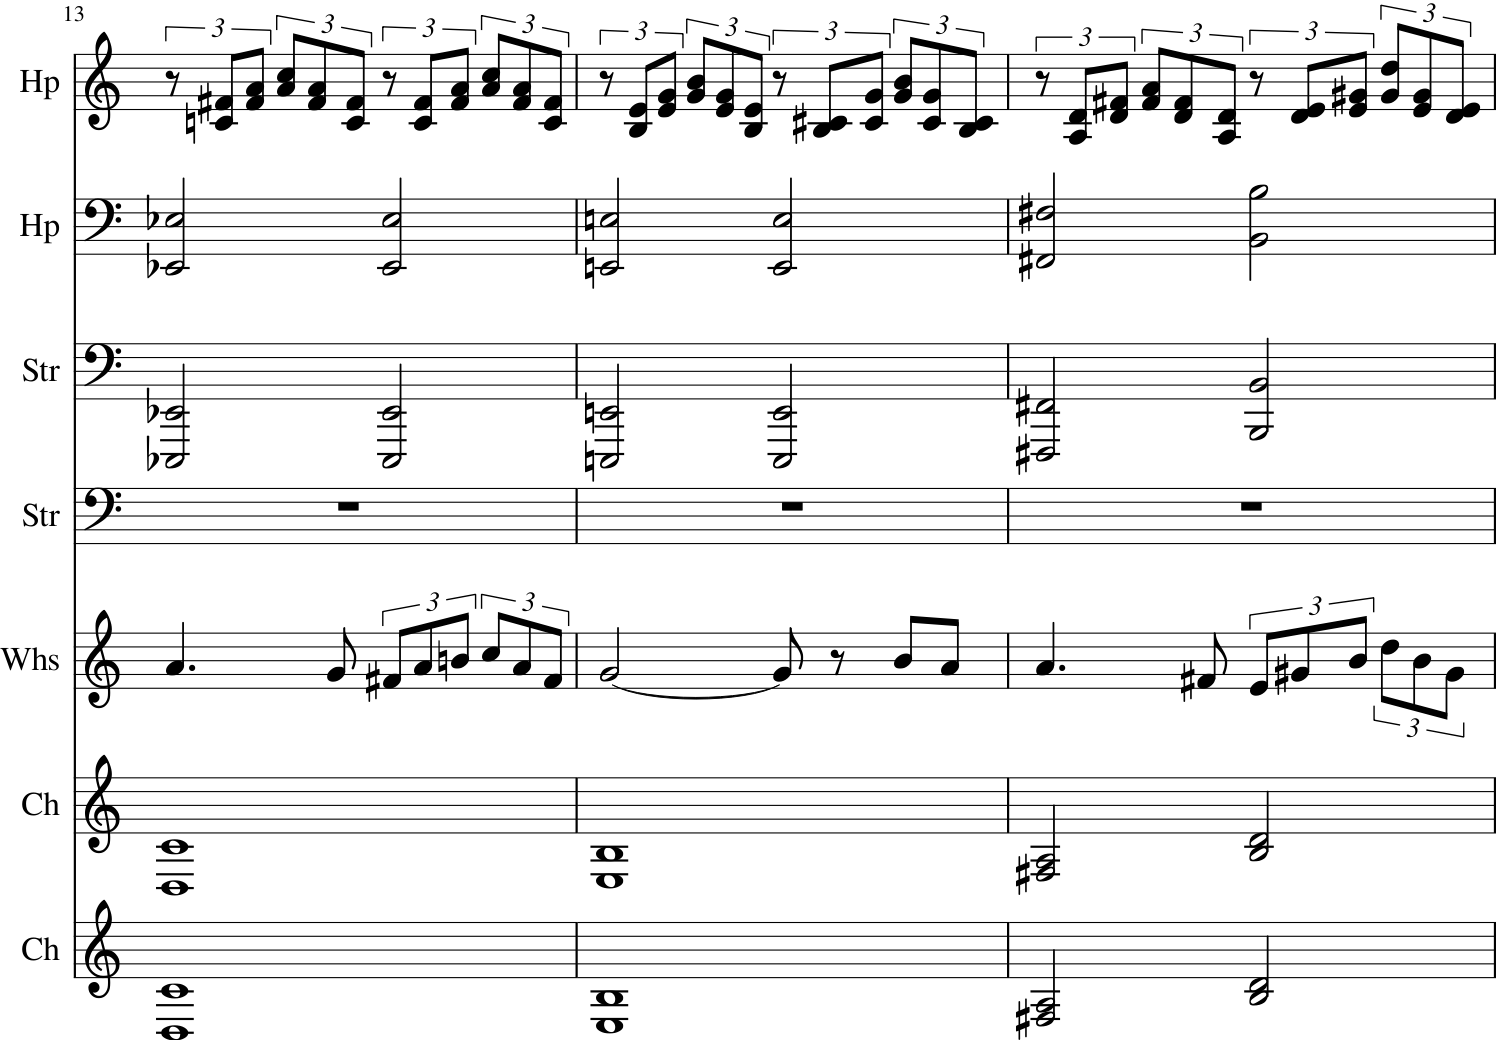

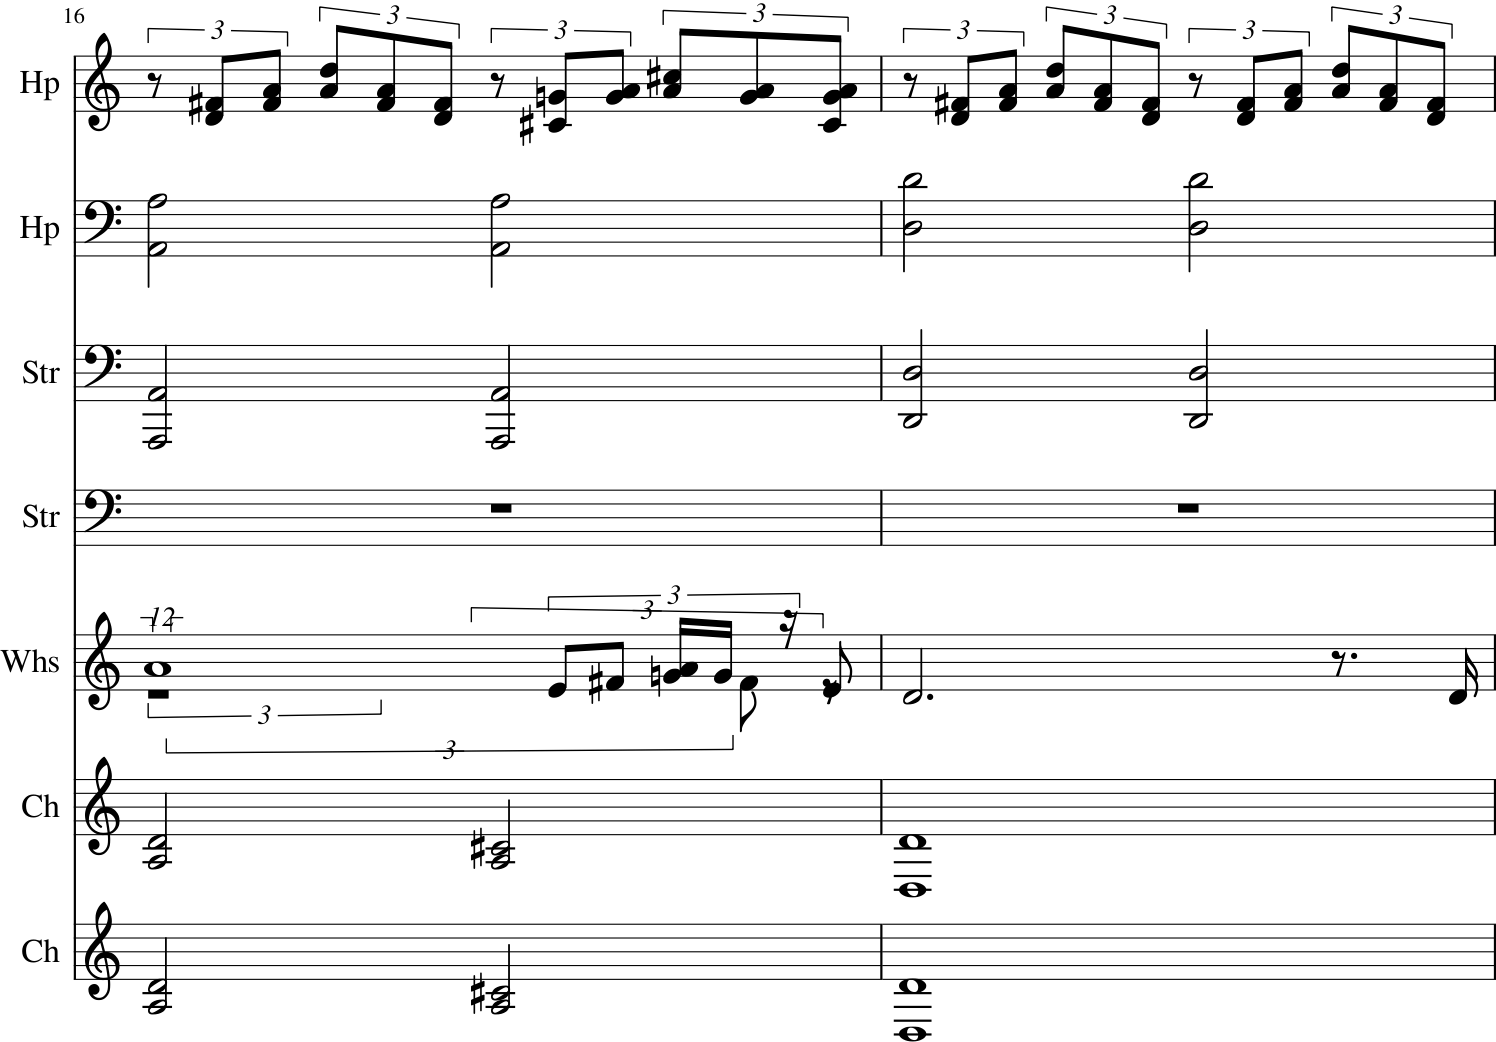

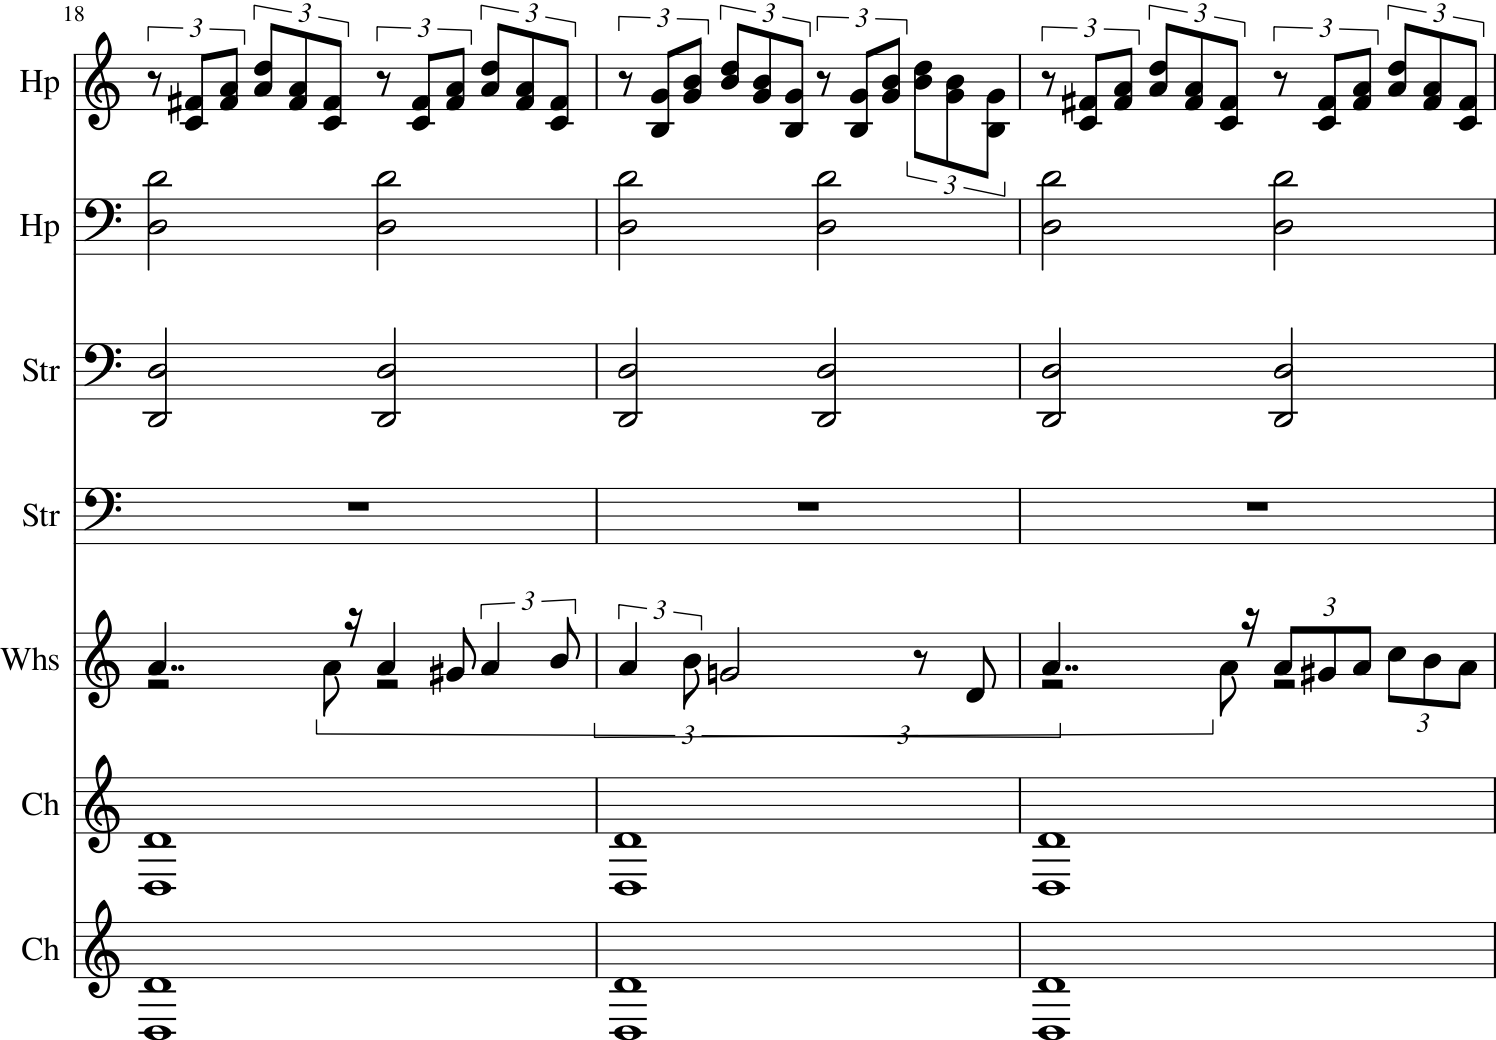

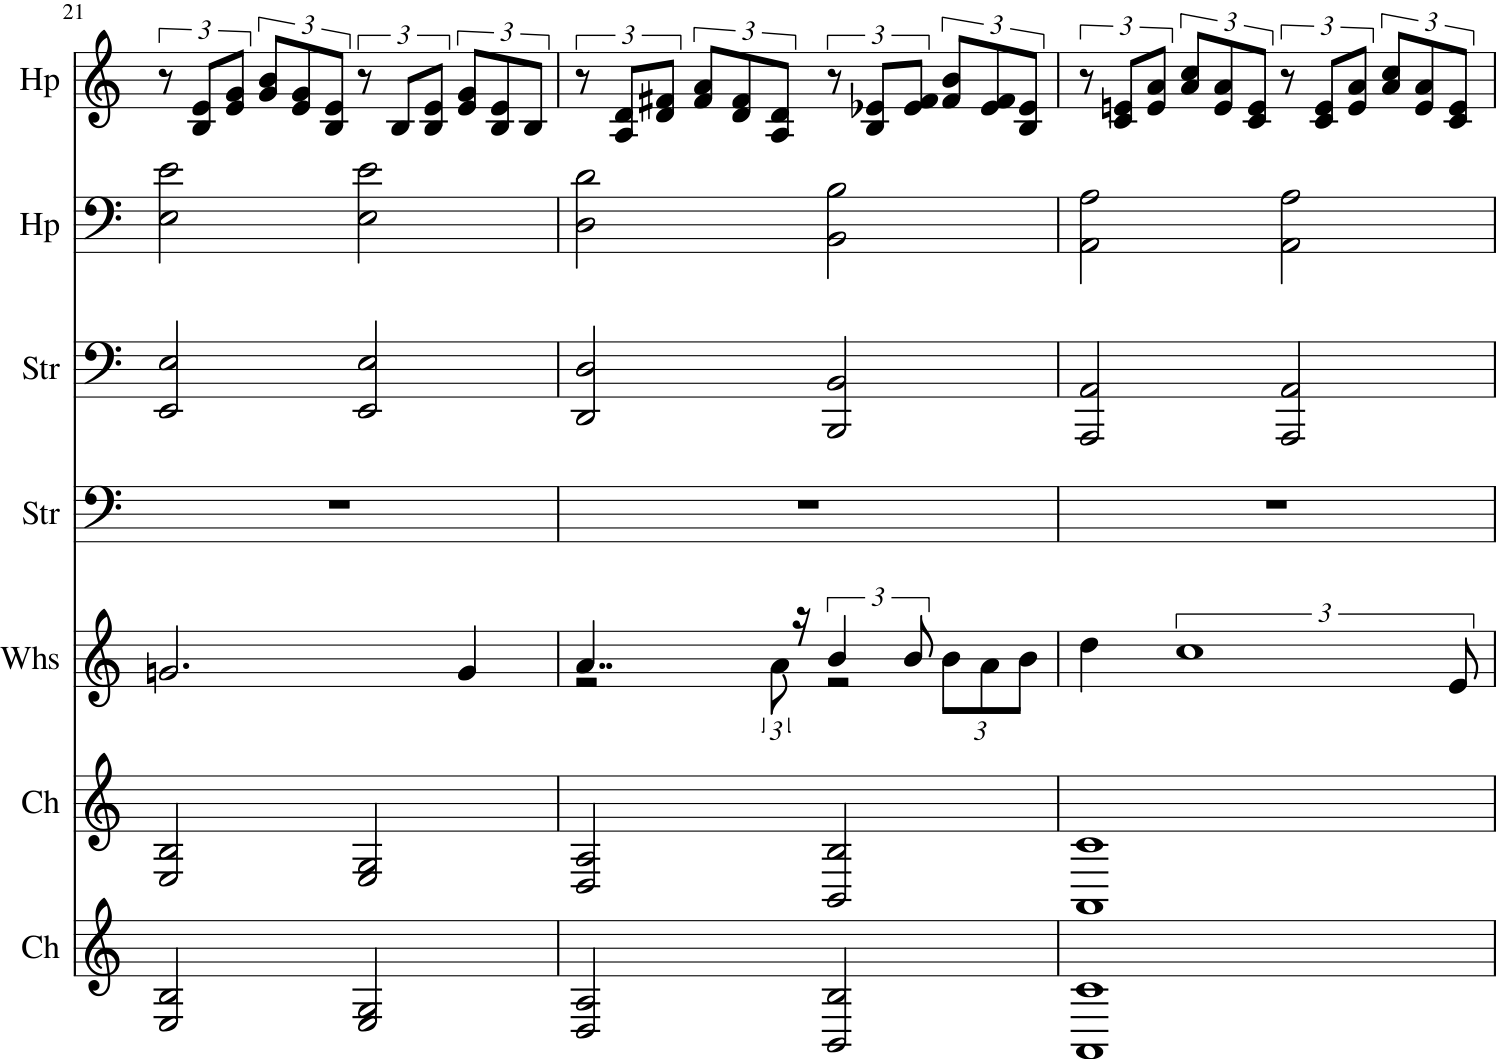

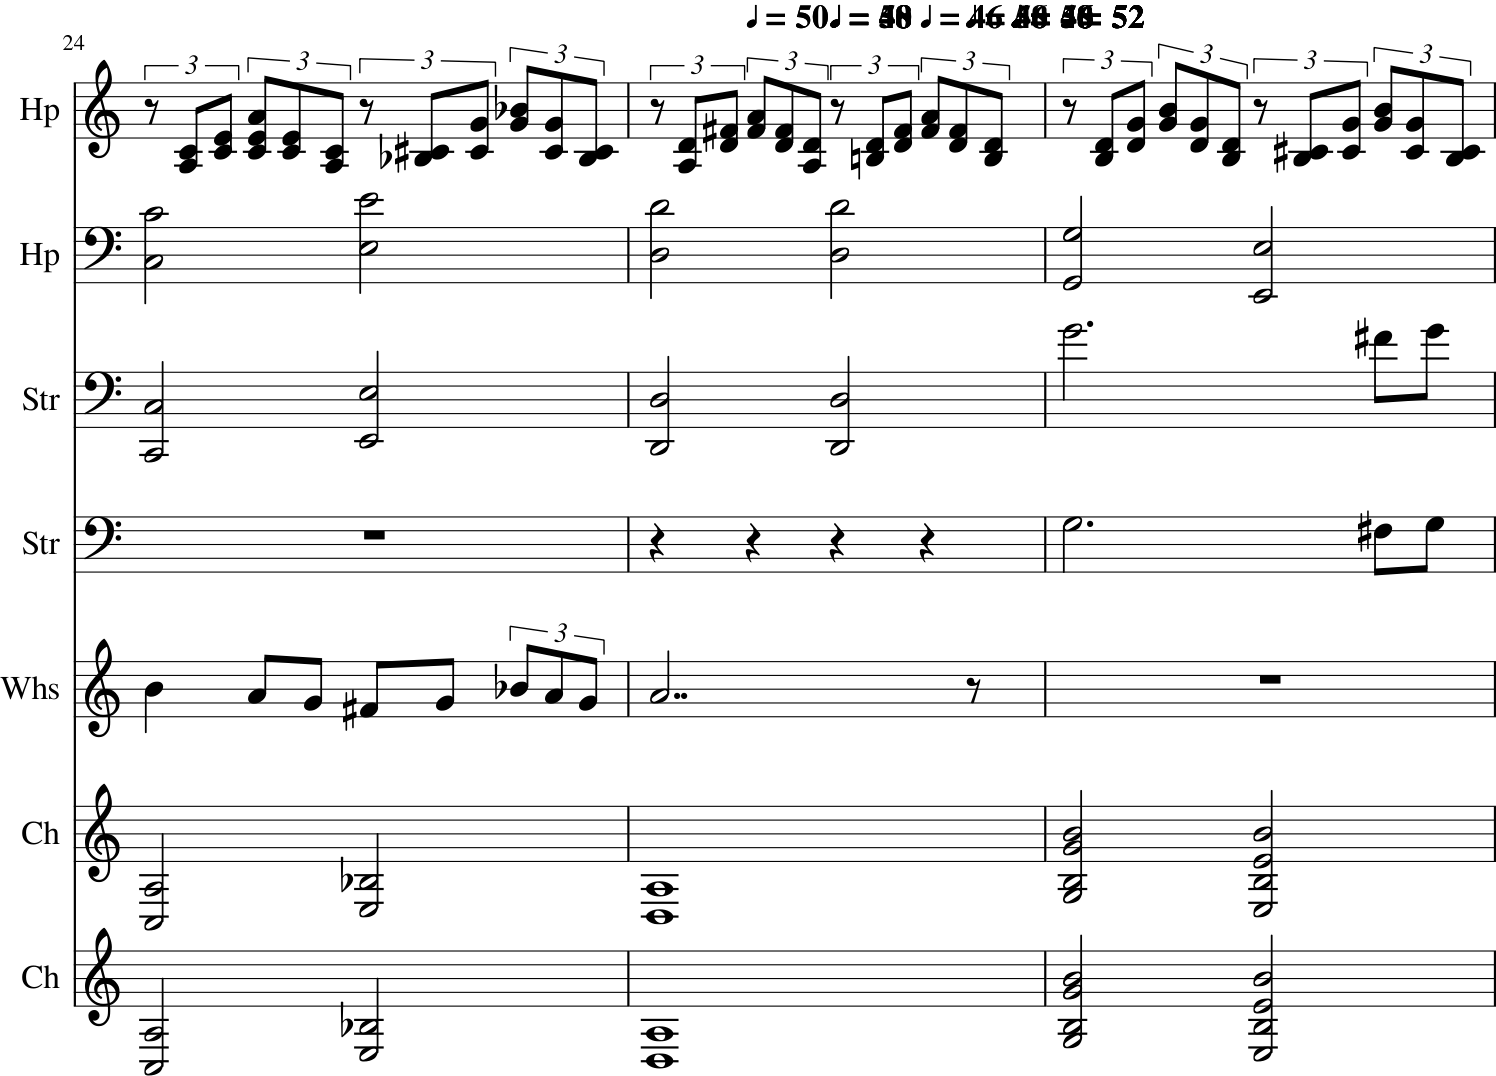

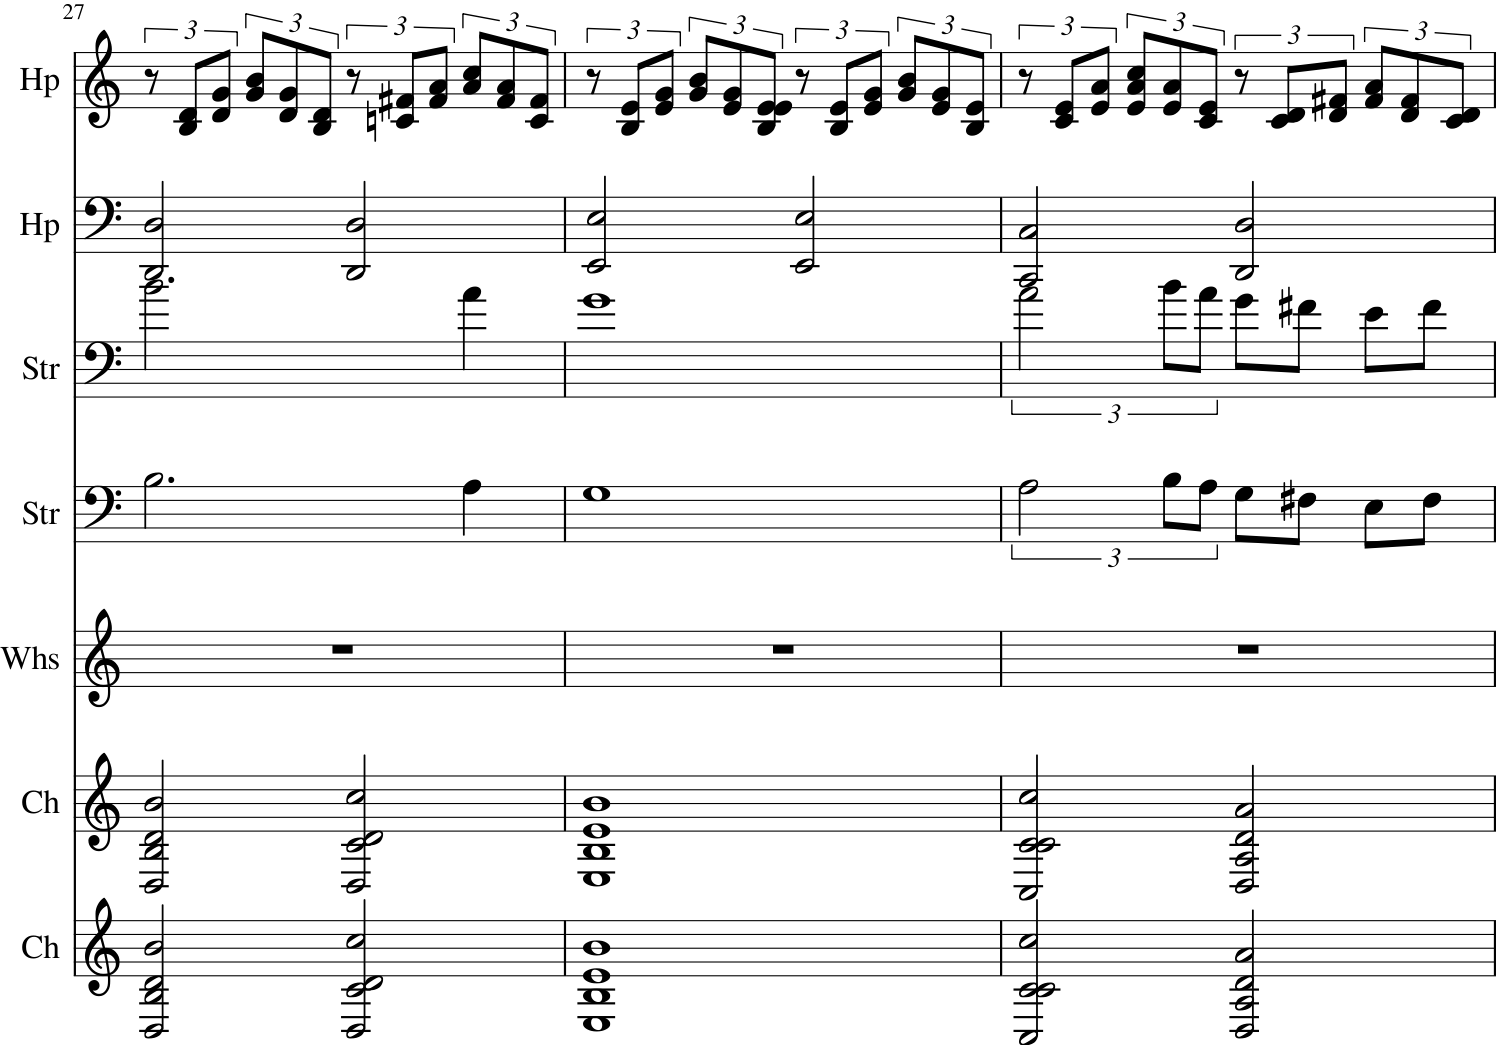

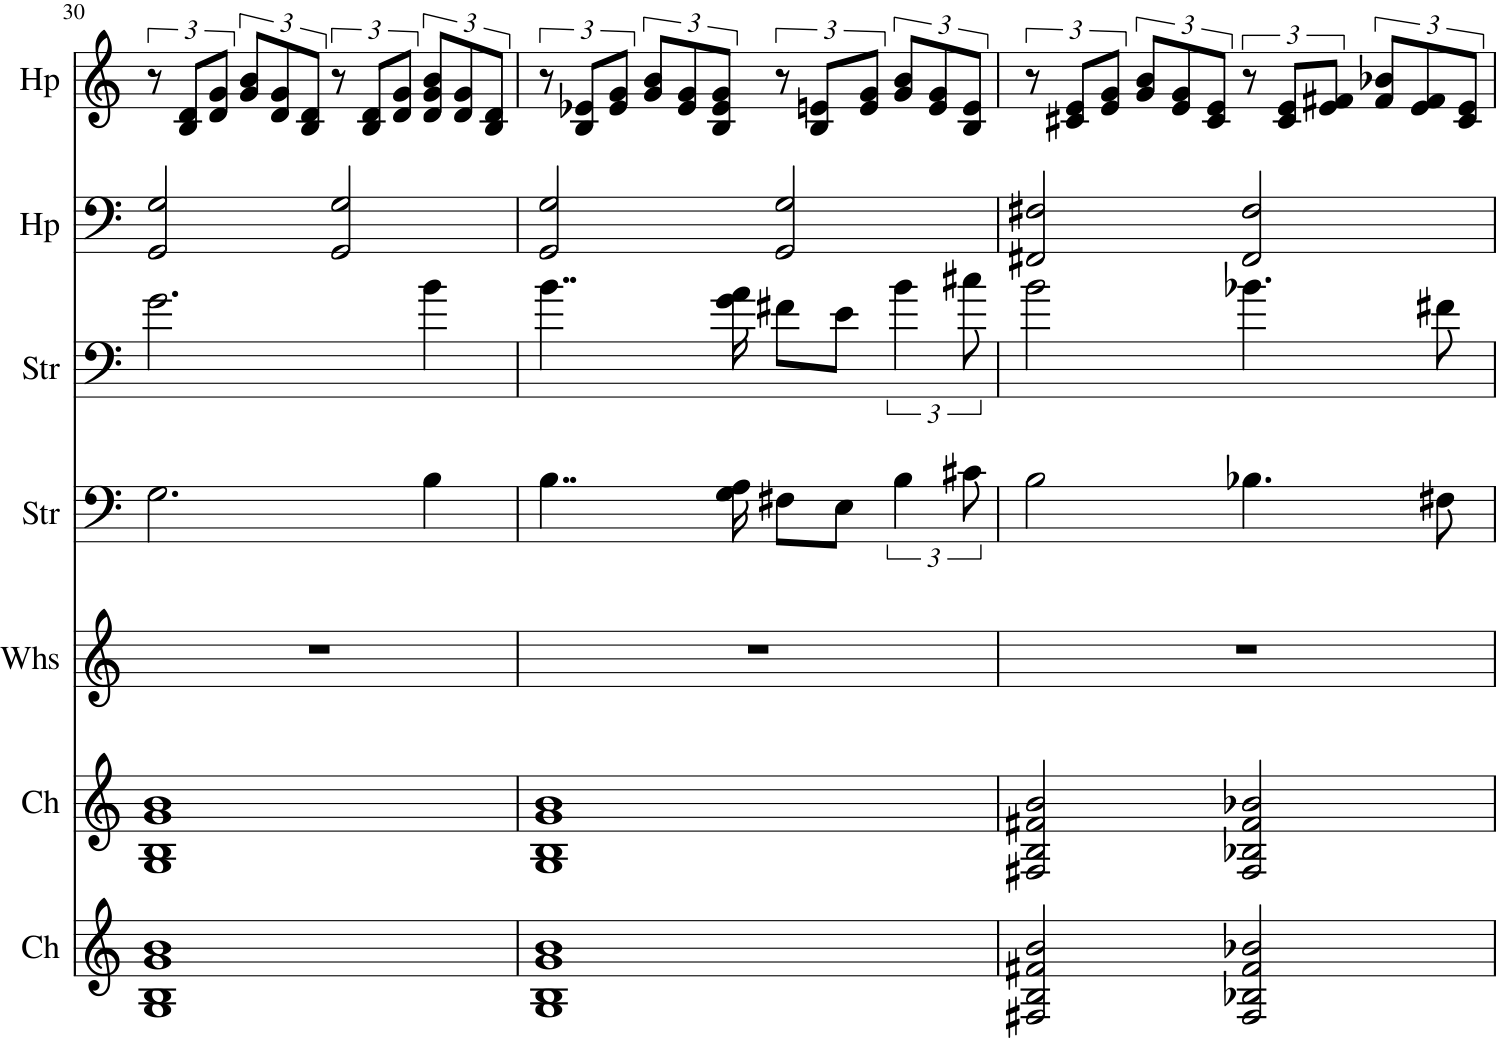

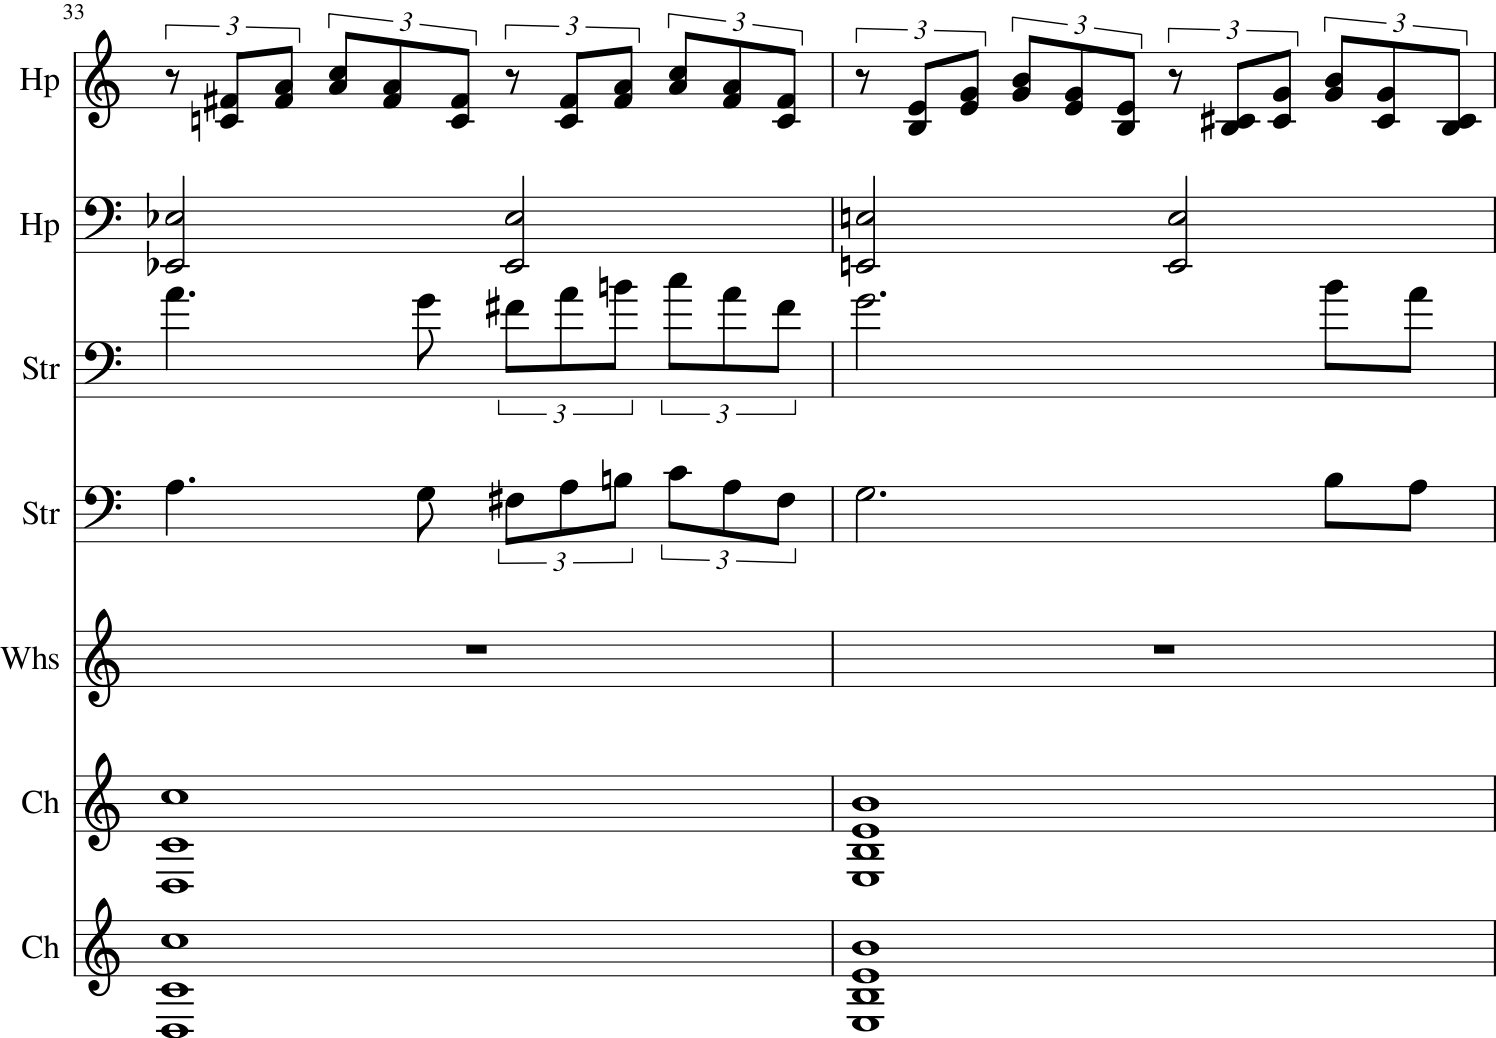

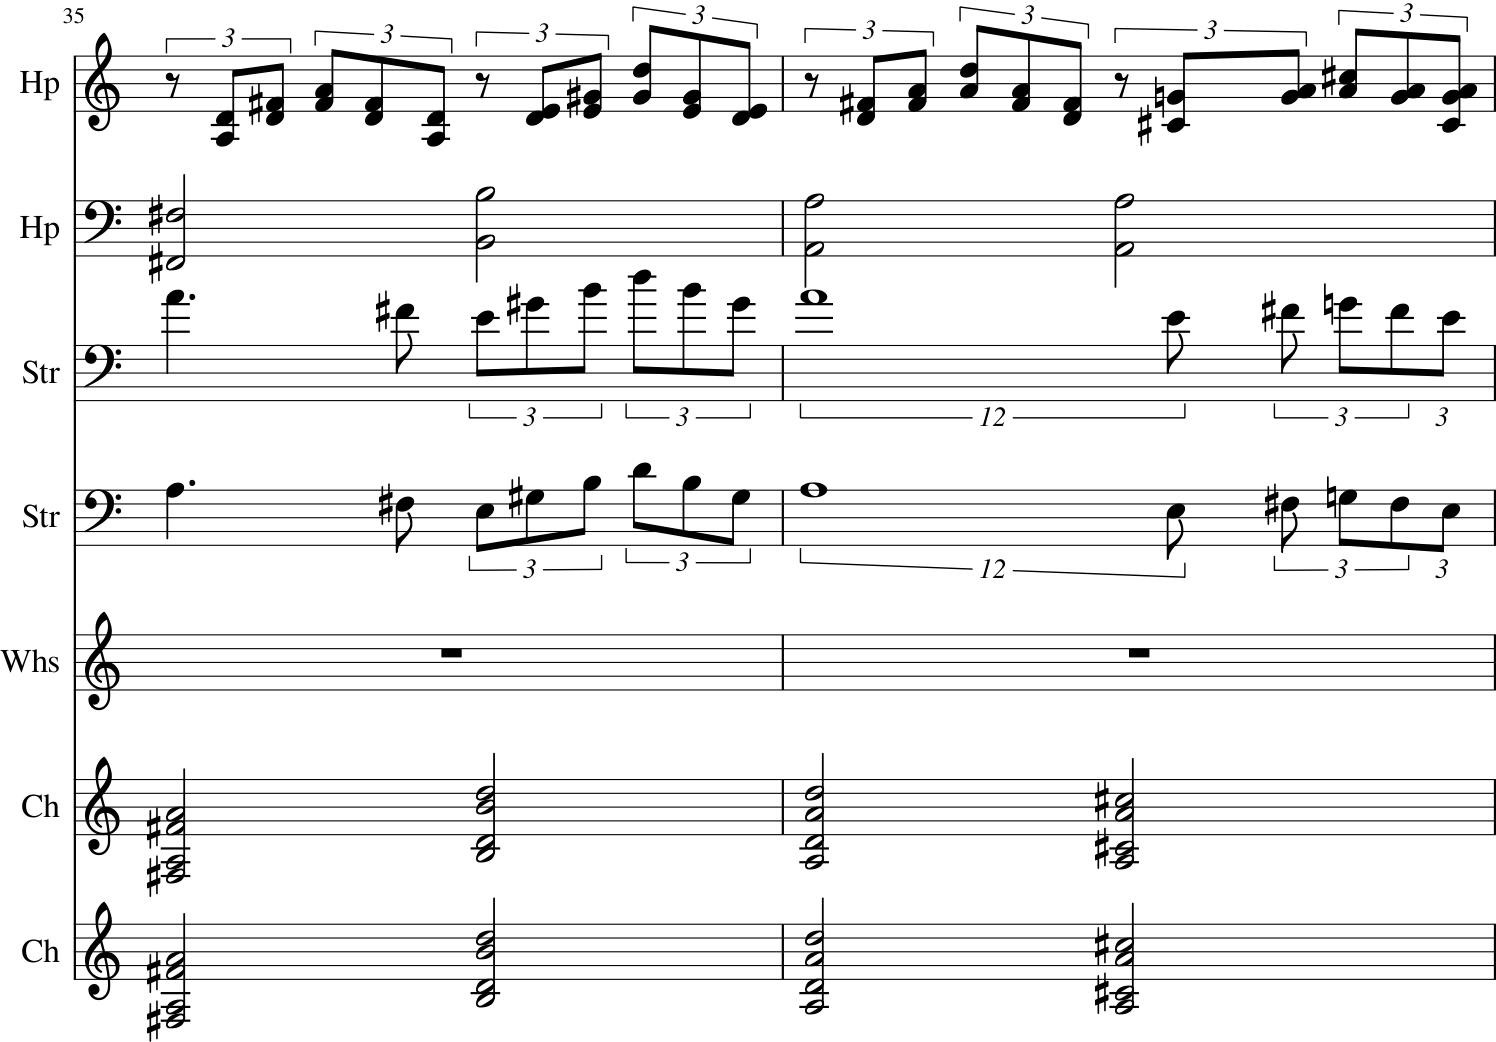

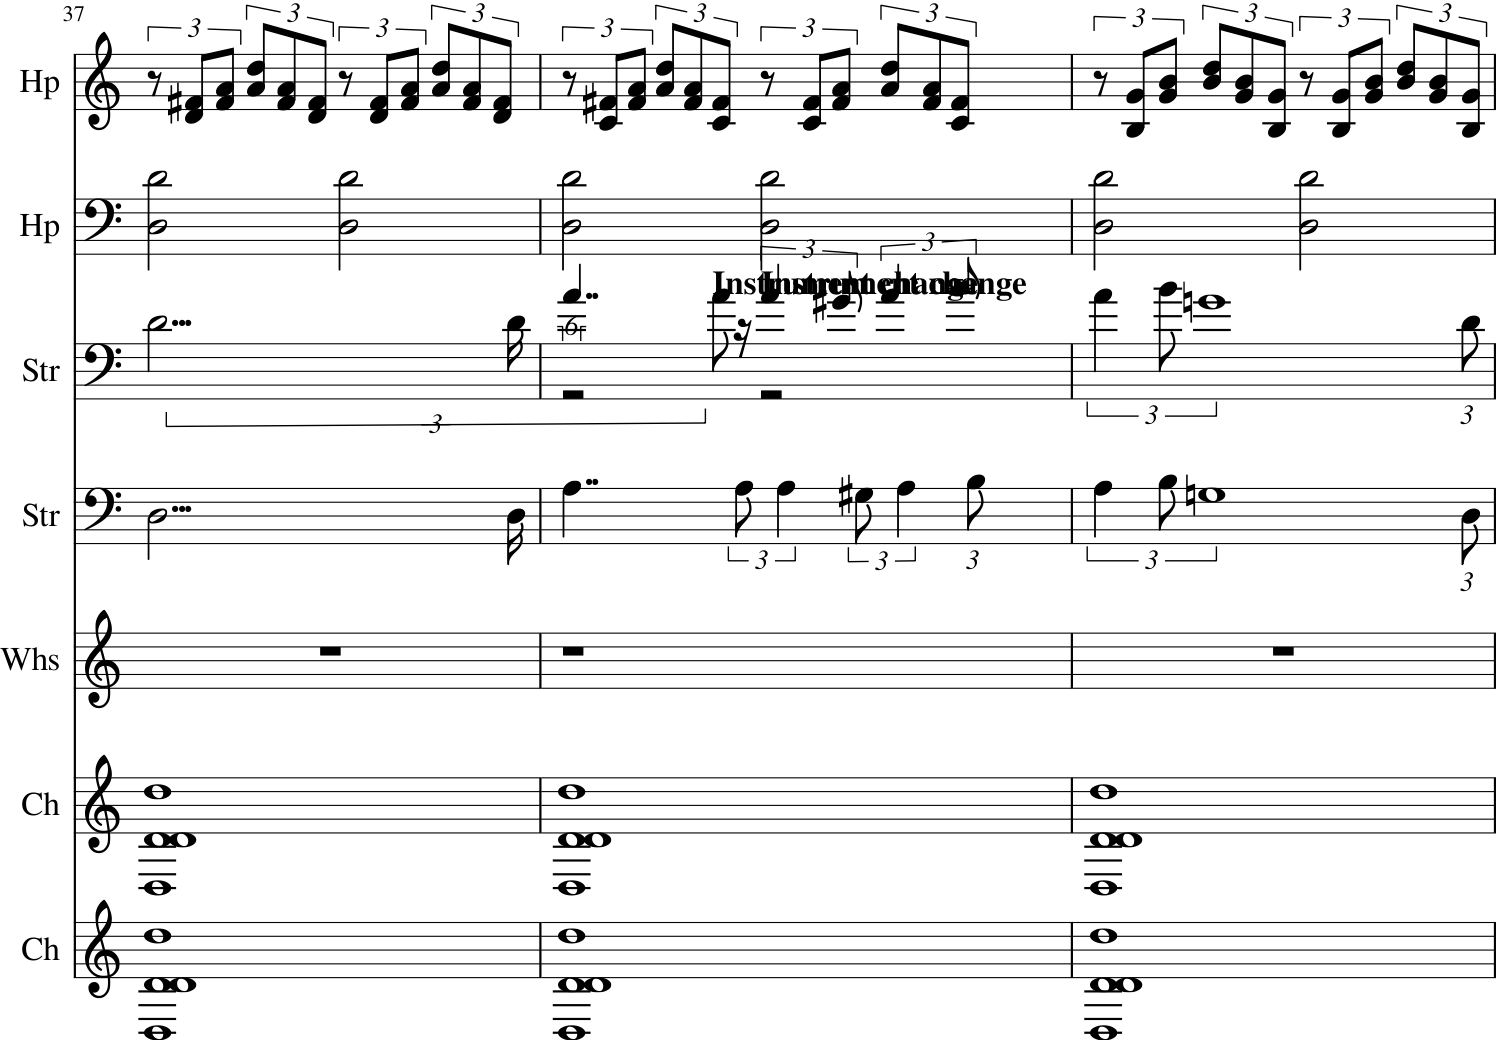

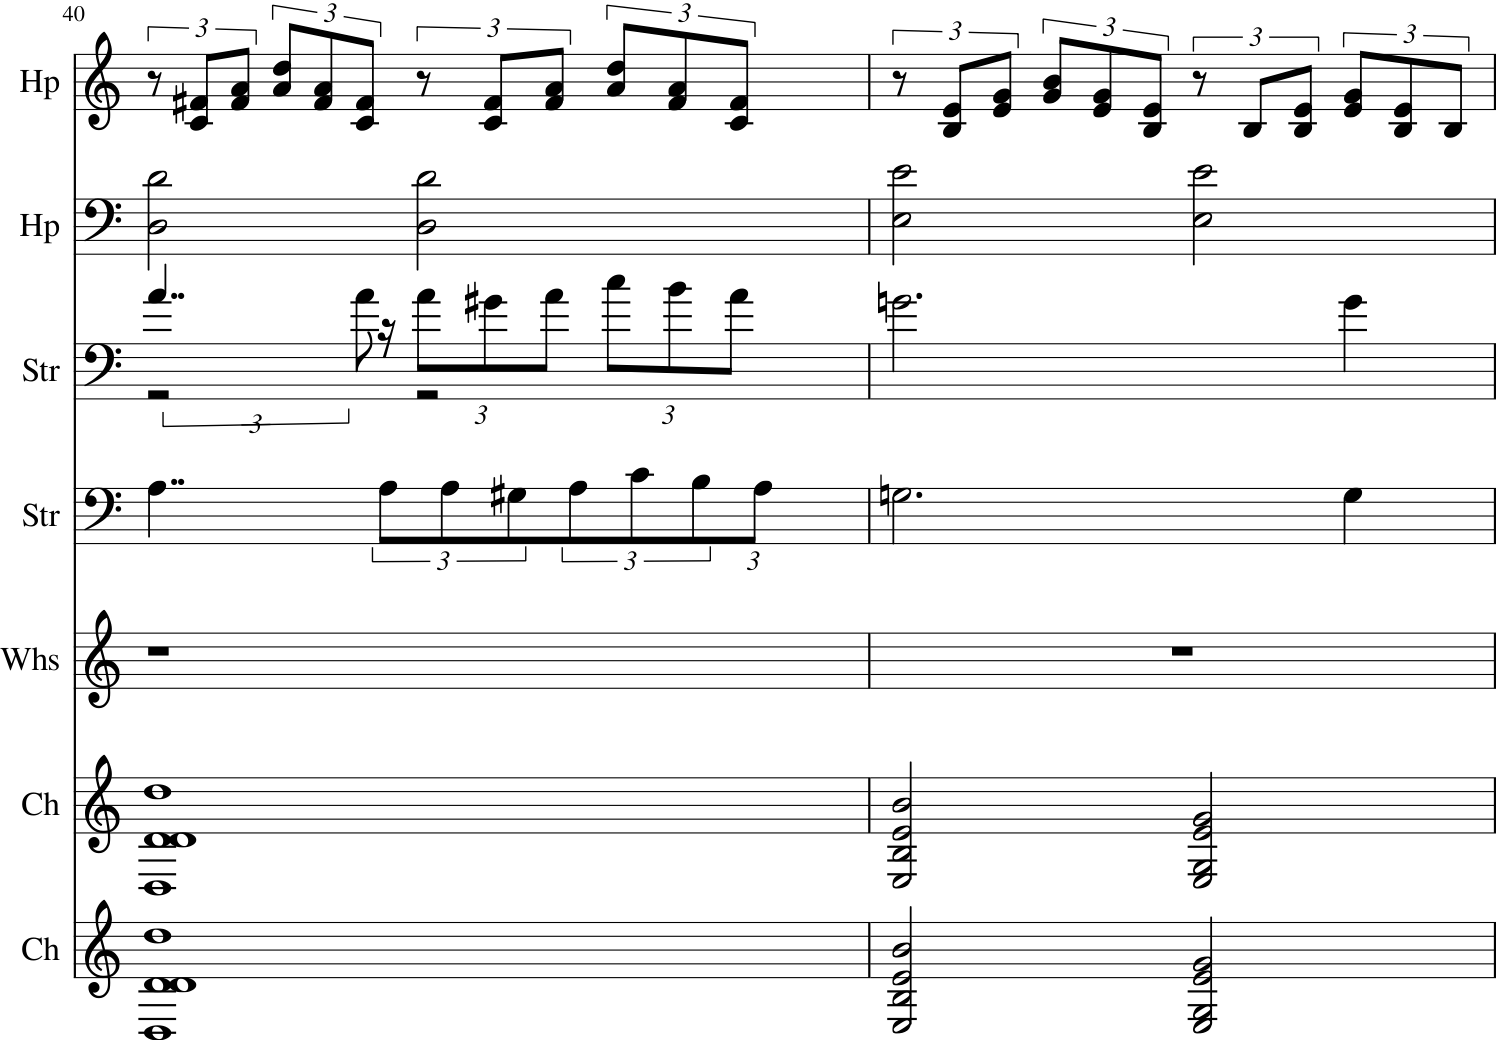

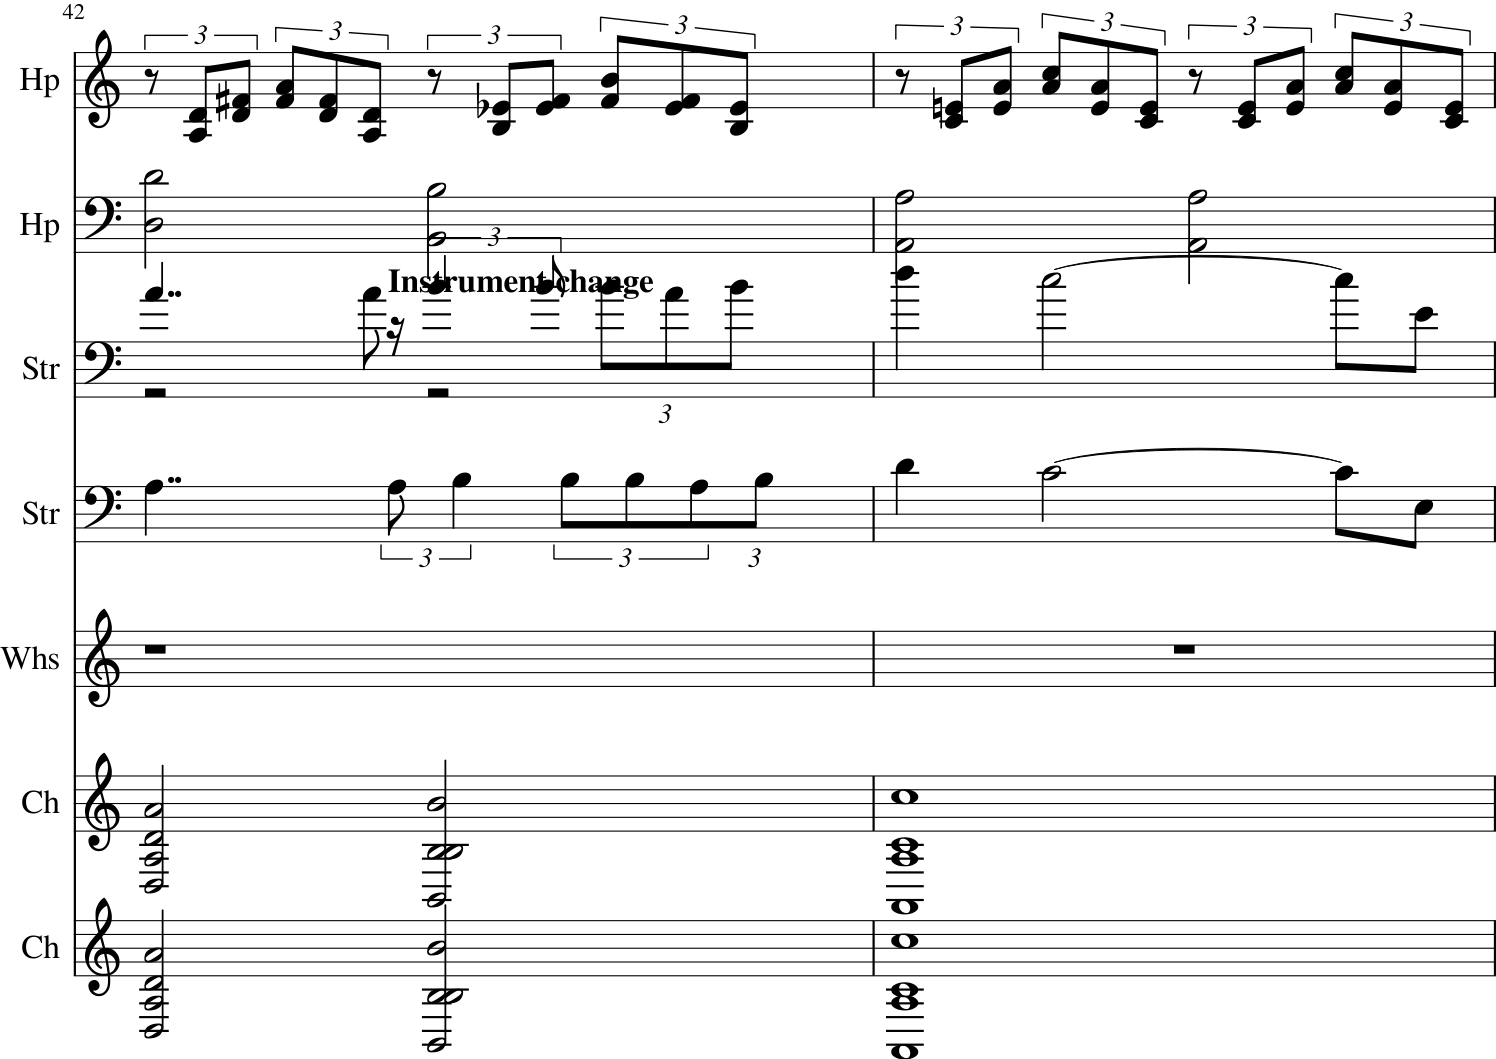

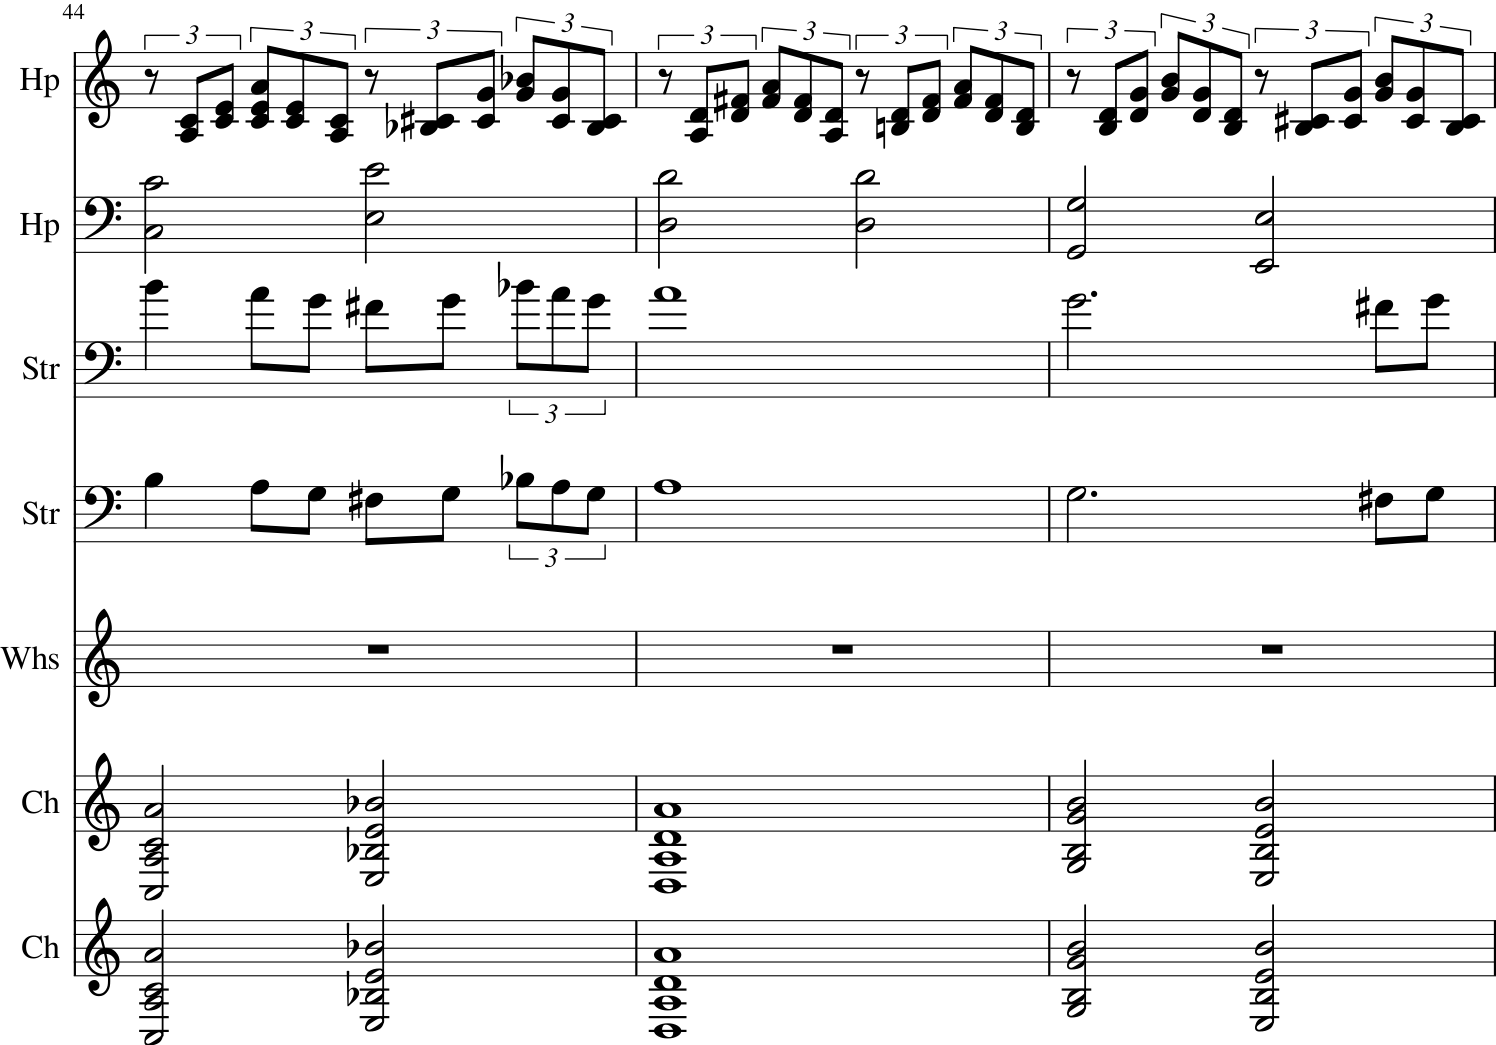

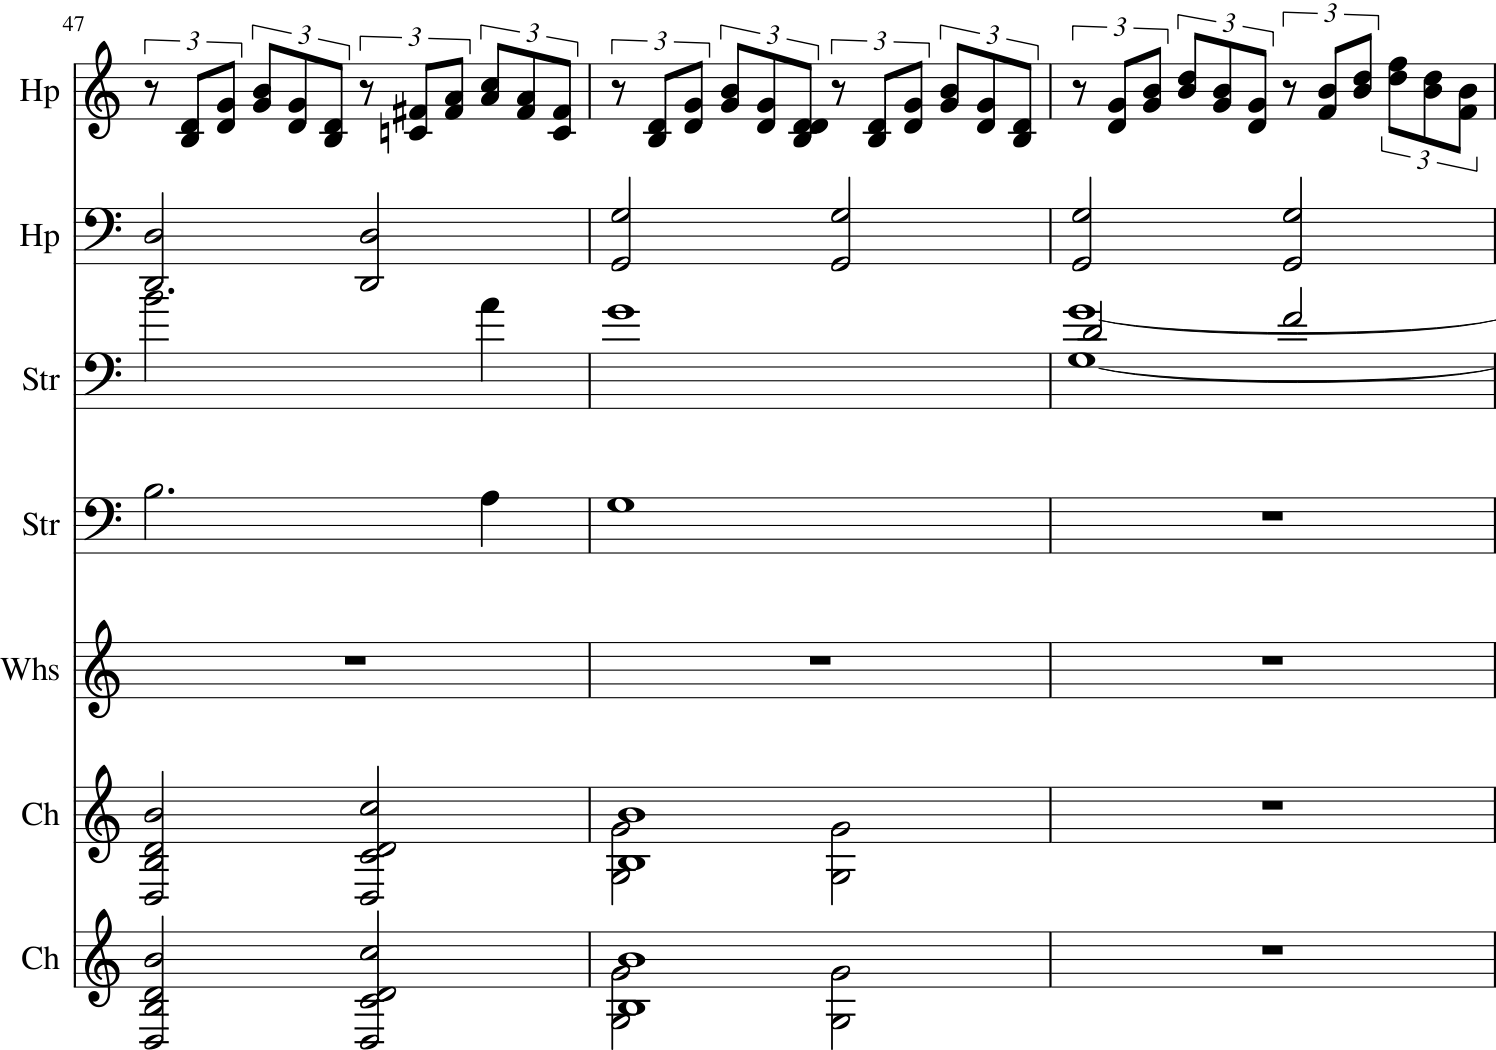

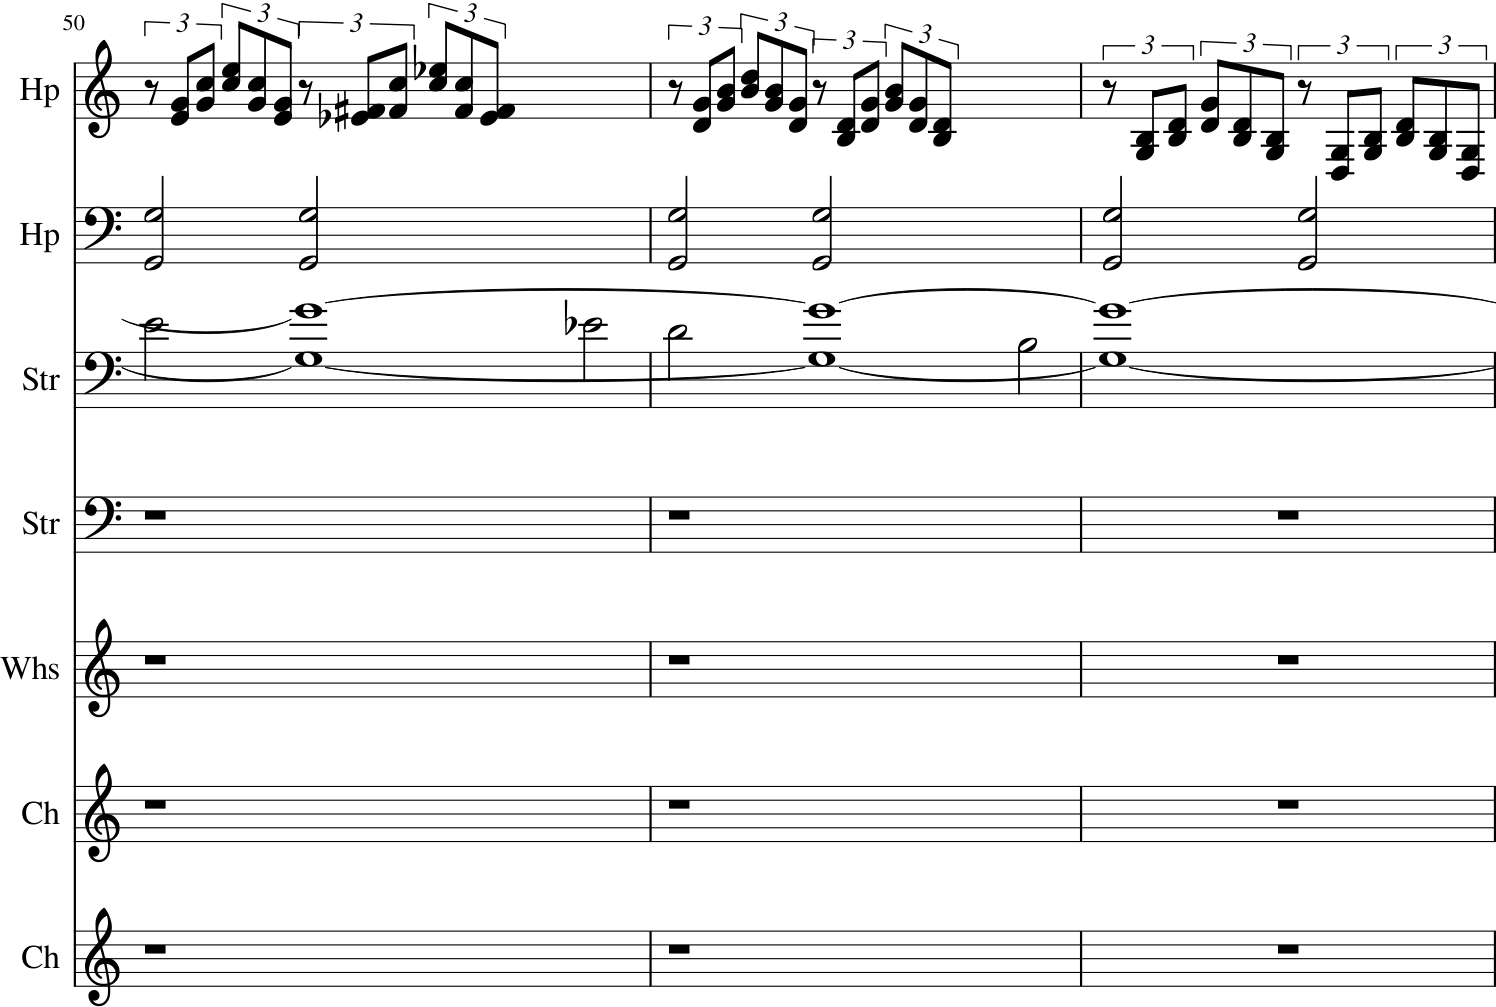

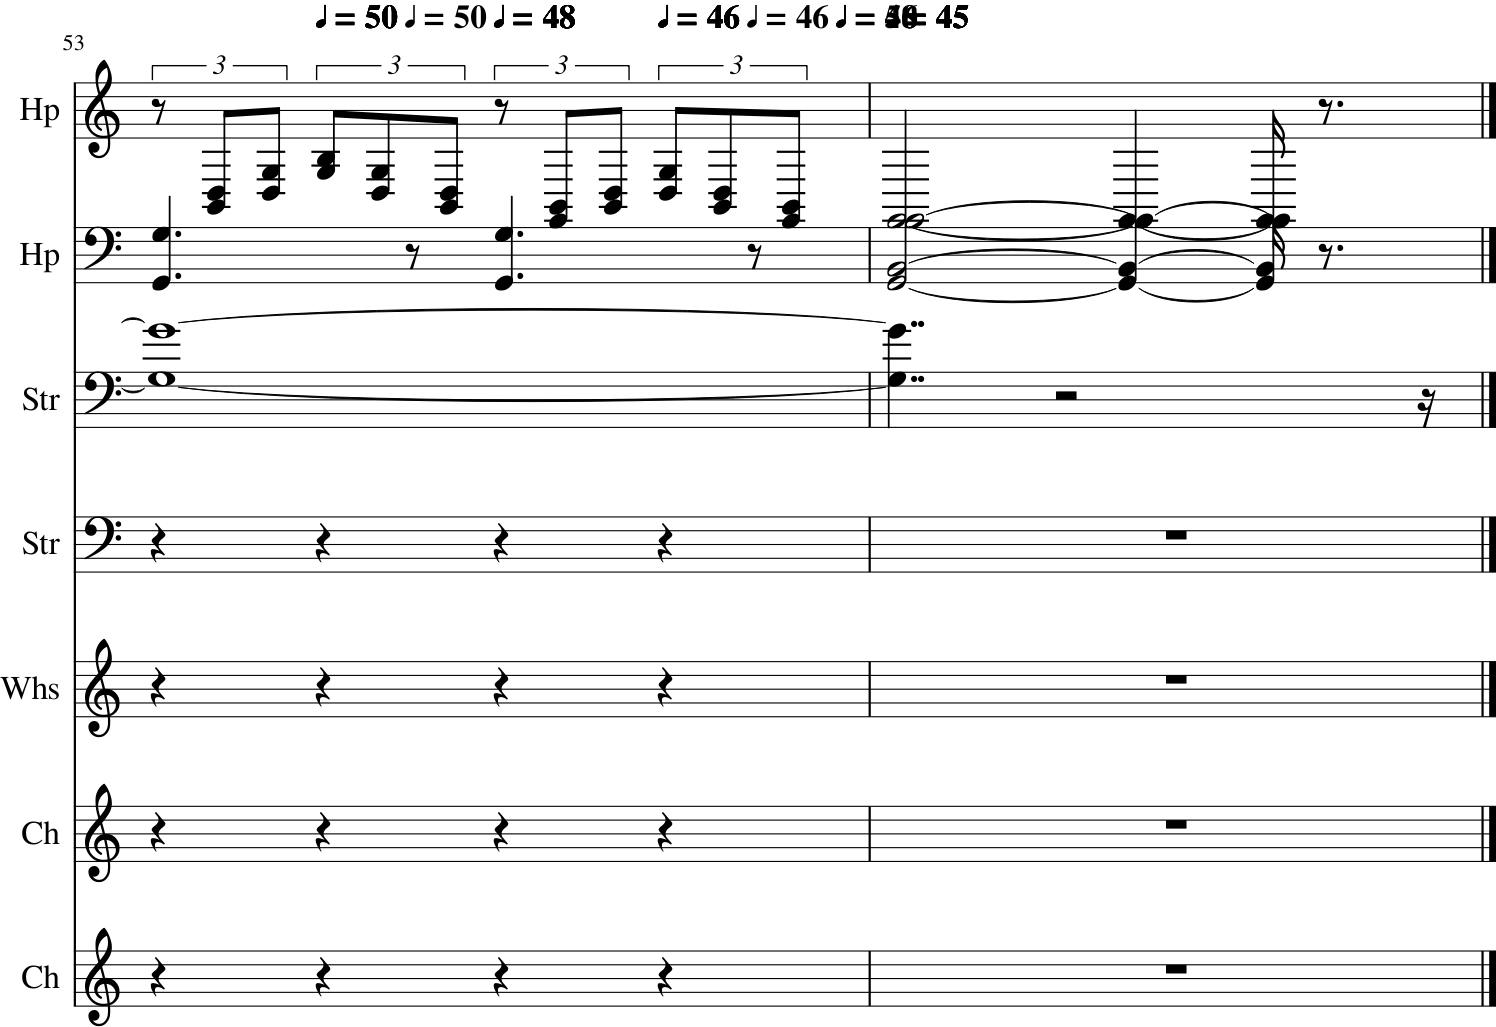

In [ ]:
music_file = midi.MidiFile()
music_file.open('avemaria_classical.mid')
music_file.read()
music_file.close()
stream = midi.translate.midiFileToStream(music_file)
stream.show()

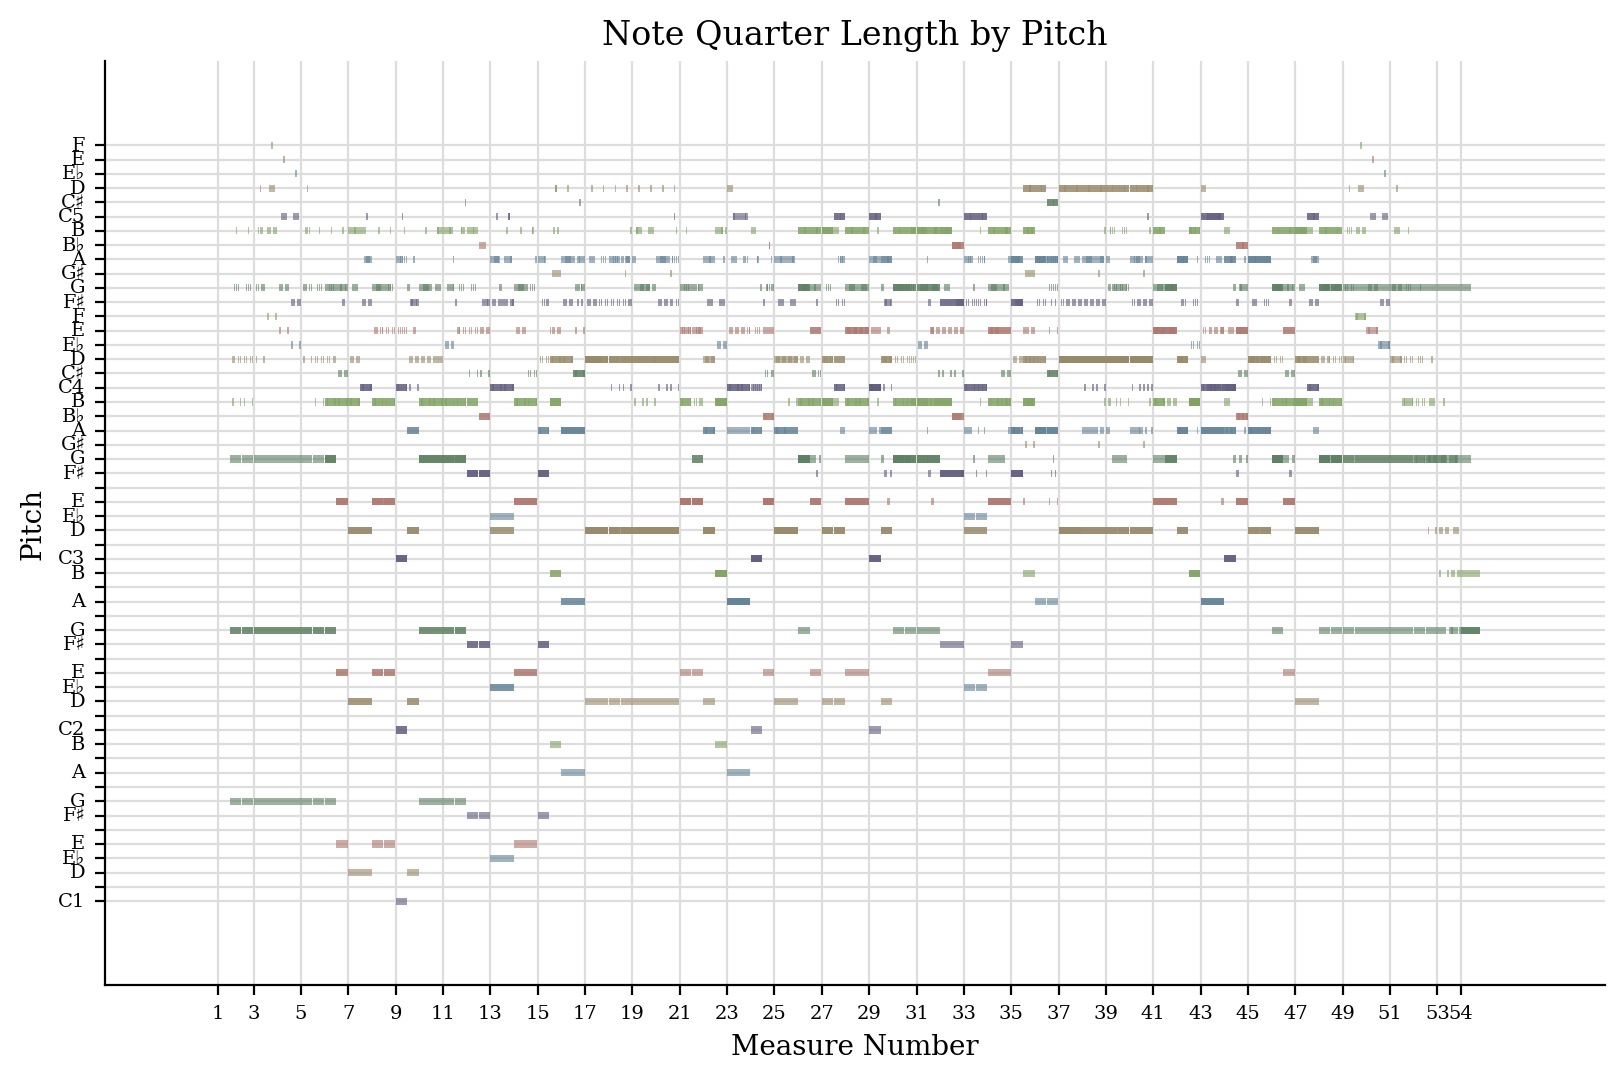

In [ ]:
stream.plot()

In [ ]:
file_name = 'avemaria_classical.mid'
prompt = torch.tensor(encode_midi(file_name))
generated_music = sample(prompt, seq_length=7245, temperature=1.5)
music_data = generated_music[0].cpu().numpy()
decode_midi(music_data, 'gen_music_HiTemp_AV.midi')
files.download('gen_music_HiTemp_AV.midi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
music_file = midi.MidiFile()
music_file.open('gen_music_HiTemp_AV.midi')
music_file.read()
music_file.close()
stream = midi.translate.midiFileToStream(music_file)
stream.show()